Define functions to load in tables of varying depth

In [1]:
import pandas as pd
def filter_df(fname):
    # Load the entire DataFrame from a Parquet file
    df = pd.read_parquet(path + fname + '.parquet')

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype('float32')

        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)

    return df

def depth1_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = df[df['num_group1'] == 0]
    filfeats = filfeats.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    df = df[df['num_group1'] == 0]
    df = df[df['num_group2'] == 0]
    filterdf = df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    return pd.merge(filterdf, aggfeats, how='left', on='case_id') 

In [1]:
import pandas as pd
def filter_df(fname):
    # Load the entire DataFrame from a Parquet file
    df = pd.read_parquet(path + fname + '.parquet')

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype('float32')

        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)

    return df
def depth1_feats(df):
    # Filter first
    filtered_df = df[df['num_group1'] == 0]
    
    numeric_cols = filtered_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = filtered_df.groupby('case_id')[numeric_cols].agg('sum').reset_index()
    
    notnum_cols = filtered_df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = filtered_df.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    # Filter first
    filtered_df = df[(df['num_group1'] == 0) & (df['num_group2'] == 0)]
    
    numeric_cols = filtered_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = filtered_df.groupby('case_id')[numeric_cols].agg('sum').reset_index()
    
    notnum_cols = filtered_df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filterdf = filtered_df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    
    return pd.merge(filterdf, aggfeats, how='left', on='case_id')

Load in base table

In [2]:
path = '/rds/general/user/ms2524/home/amexproject/parquet_files/train/train_'
base_cba = pd.read_parquet(path + "base.parquet", columns=['case_id','WEEK_NUM','target'])

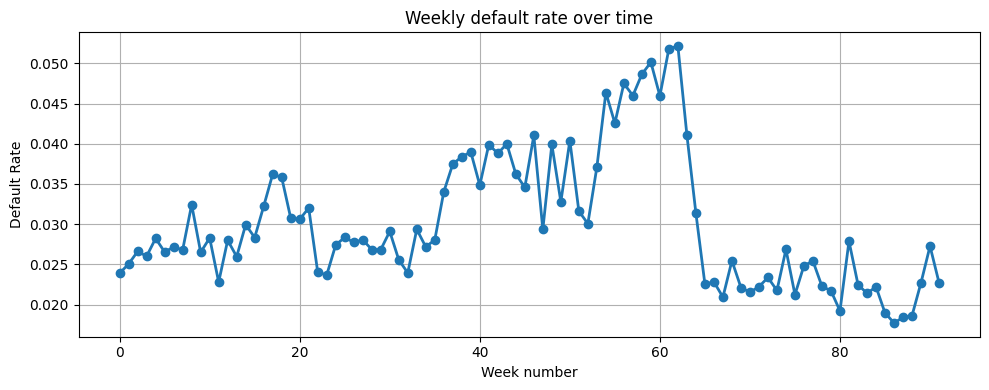

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

weekly_defaults = (
    base_cba
    .groupby('WEEK_NUM')['target']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(weekly_defaults['WEEK_NUM'], weekly_defaults['target'], marker='o', linewidth=2)
plt.title('Weekly default rate over time')
plt.xlabel('Week number')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/weekly_default_rate.pdf', format='pdf')
plt.show()


## Depth = 2

### Credit Bureua A

In [3]:
all_chunks = []
for id in range(11):
    df = filter_df(f'credit_bureau_a_2_{id}')
    processed = depth2_feats(df)
    all_chunks.append(processed)

# Concatenate everything at once
tmp = pd.concat(all_chunks, ignore_index=True)

# Merge with base
data_cba = pd.merge(base_cba, tmp, how="left", on="case_id")


### Previous application

In [4]:
data_appl = pd.merge(
    base_cba,
    depth2_feats(filter_df('applprev_2')),
    how="left",
    on="case_id"
)


## Depth = 1

### Credit Bureua A

In [5]:
data_cba = pd.merge(
    data_cba,
    depth1_feats(pd.concat([filter_df(f'credit_bureau_a_1_{id}') for id in range(4)])),
    how="left",
    on="case_id"
)

### Previous application

In [6]:
data_appl = pd.merge(
    data_appl,
    depth1_feats(pd.concat([filter_df(f'applprev_1_{id}') for id in range(2)])),
    how="left",
    on="case_id"
)


### Train person

In [7]:
data_person_1_train = pd.merge(
    base_cba,
    depth1_feats(filter_df('person_1')),
    how="left",
    on="case_id"
)

## Depth = 0

### Train Static

In [8]:
columns_to_keep = [
    'case_id', 'annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 
    'eir_270L', 'pmtnum_254L', 'lastst_736L', 'totalsettled_863A', 
    'numrejects9m_859L', 'currdebt_22A'
]

data_static_train = pd.merge(
    base_cba,
    pd.concat([
        filter_df(f'static_0_{id}')[columns_to_keep]
        for id in range(2)
    ], ignore_index=True),
    how="left",
    on="case_id"
)

## Feature selection 

In [9]:
for col in data_cba.columns:
    if col.endswith('D'):
        data_cba[col] = pd.to_datetime(data_cba[col], errors='coerce')


for col in data_cba.select_dtypes(include=['object']).columns:
    data_cba[col] = data_cba[col].astype('category')

for col in data_appl.columns:
    if col.endswith('D'):
        data_appl[col] = pd.to_datetime(data_appl[col], errors='coerce')

for col in data_appl.select_dtypes(include=['object']).columns:
    data_appl[col] = data_appl[col].astype('category')

for col in data_static_train.columns:
    if col.endswith('D'):
        data_static_train[col] = pd.to_datetime(data_static_train[col], errors='coerce')

for col in data_static_train.select_dtypes(include=['object']).columns:
    data_static_train[col] = data_static_train[col].astype('category')

for col in data_person_1_train.columns:
    if col.endswith('D'):
        data_person_1_train[col] = pd.to_datetime(data_person_1_train[col], errors='coerce')

for col in data_person_1_train.select_dtypes(include=['object']).columns:
    data_person_1_train[col] = data_person_1_train[col].astype('category')

In [10]:
import numpy as np
cb_features = ['case_id', 'WEEK_NUM','pmts_dpd_1073P', 'pmts_dpd_303P', 'dpdmax_139P', 'numberofoverdueinstlmax_1039L', 'numberofoverdueinstls_725L', 'collaterals_typeofguarante_359M', 'classificationofcontr_400M', 'subjectrole_93M', 'target']
data1_cba=data_cba[cb_features]
data1_cba = data1_cba.copy()
data1_cba.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

applprev_features = ['case_id', 'WEEK_NUM','maxdpdtolerance_577P', 'cacccardblochreas_147M', 'rejectreason_755M','target']
data1_appl=data_appl[applprev_features]
data1_appl = data1_appl.copy()
data1_appl.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

static_features = ['case_id', 'WEEK_NUM','annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 'eir_270L', 'pmtnum_254L', 'lastst_736L']
data_static_train_1 = data_static_train[static_features]
data_static_train_1 = data_static_train_1.copy()
data_static_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

person_features = ['case_id', 'WEEK_NUM','personindex_1023L', 'persontype_1072L', 'persontype_792L', 'empladdr_zipcode_114M', 'incometype_1044T', 'safeguarantyflag_411L', 'type_25L','target']
data_person_1_train_1 = data_person_1_train[person_features]
data_person_1_train_1 = data_person_1_train_1.copy()
data_person_1_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np


# Split by WEEK_NUM into equal segments
def split_by_week(df, n):
    min_week = df["WEEK_NUM"].min()
    max_week = df["WEEK_NUM"].max()
    bins = np.linspace(min_week, max_week + 1, n + 1, dtype=int)

    segments = {}
    for i in range(n):
        lower = bins[i]
        upper = bins[i + 1]
        key = f"split_{i}"
        segments[key] = df[(df["WEEK_NUM"] >= lower) & (df["WEEK_NUM"] < upper)].copy()

    return segments

def preprocess_split(train_df, test_df):
    exclude_columns = {'case_id', 'WEEK_NUM', 'target'}
    numcols = []
    catcols = []

    # Separate numeric and categorical columns
    for col in train_df.columns:
        if col in exclude_columns:
            continue
        if pd.api.types.is_numeric_dtype(train_df[col]):
            numcols.append(col)
        elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
            catcols.append(col)

    # Impute numeric columns
    for col in numcols:
        if train_df[col].isnull().any():
            strategy = 'median' if abs(train_df[col].skew()) > 0.5 else 'mean'
            imputer = SimpleImputer(strategy=strategy)
            train_df[[col]] = imputer.fit_transform(train_df[[col]])
            test_df[[col]] = imputer.transform(test_df[[col]])

    # Handle categorical columns: fill NA with "Unknown"
    for col in catcols:
        for df in [train_df, test_df]:
            if "Unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("Unknown")

        # Fill missing values
        train_df[col] = train_df[col].fillna("Unknown")
        test_df[col] = test_df[col].fillna("Unknown")

    # Ordinal encode
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[catcols] = encoder.fit_transform(train_df[catcols])
    test_df[catcols] = encoder.transform(test_df[catcols])

    return train_df, test_df

def preprocess_all_segments(df, n):
    segments = split_by_week(df, n)
    base_train = segments["split_0"].copy()
    processed_segments = {}

    for key, segment_df in segments.items():
        train_proc, test_proc = preprocess_split(base_train.copy(), segment_df.copy())
        processed_segments[key] = test_proc

    return processed_segments

In [12]:
def merge_all_segments(cba_splits, static_splits, person_splits, appl_splits):
    merged_segments = {}

    drop_cols = ['WEEK_NUM', 'target']

    for split_name in cba_splits:
        cba = cba_splits[split_name]
        static = static_splits[split_name].drop(columns=[col for col in drop_cols if col in static_splits[split_name].columns])
        person = person_splits[split_name].drop(columns=[col for col in drop_cols if col in person_splits[split_name].columns])
        appl = appl_splits[split_name].drop(columns=[col for col in drop_cols if col in appl_splits[split_name].columns])

        merged = cba.merge(static, on="case_id", how="inner") \
                    .merge(person, on="case_id", how="inner") \
                    .merge(appl, on="case_id", how="inner")

        merged_segments[split_name] = merged

    return merged_segments


In [13]:
n_segments = 40

cba_proc = preprocess_all_segments(data1_cba, n=n_segments)
static_proc = preprocess_all_segments(data_static_train_1, n=n_segments)
person_proc = preprocess_all_segments(data_person_1_train_1, n=n_segments)
appl_proc = preprocess_all_segments(data1_appl, n=n_segments)

final_segments = merge_all_segments(cba_proc, static_proc, person_proc, appl_proc)

/rds/general/user/ms2524/ephemeral/ipykernel_1711569/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_1711569/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_1711569/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral

In [14]:
all_case_ids = []

for split_name, df in final_segments.items():
    all_case_ids.extend(df['case_id'].tolist())

total_case_ids = len(all_case_ids)
unique_case_ids = len(set(all_case_ids))

print(f"Total case_ids (merged segments, with duplicates): {total_case_ids}")
print(f"Unique case_ids (merged segments): {unique_case_ids}")


Total case_ids (merged segments, with duplicates): 1526659
Unique case_ids (merged segments): 1526659


# Evaluating algorithms

## Online Gradient Descent

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np

def utility(tp, tn, fp, fn):
    #return 50*tp - 100*fn - fp * 5
    return 500*tp - 10*fn - fp * 50

def utility_function(y_true, accept_mask, profit_per_good=0, loss_per_bad=10, cost_per_reject=50):
    accepted_outcomes = y_true[accept_mask]
    rejected_outcomes = y_true[~accept_mask]
    
    utility = (np.sum(accepted_outcomes == 0) * profit_per_good +      # Profit from good loans
              np.sum(accepted_outcomes == 1) * (-loss_per_bad) +       # Loss from bad loans
              np.sum(rejected_outcomes == 0) * (-cost_per_reject) +    # Cost of rejecting good customers
              np.sum(rejected_outcomes == 1) * 500)                      # No cost for rejecting bad customers
    
    return utility

def learn_optimal_threshold(model, scaler, X_val, y_val, 
                          profit_per_good=100, loss_per_bad=500, cost_per_reject=10):
    thresholds = np.arange(0.01, 0.99, 0.02)
    X_val_scaled = scaler.transform(X_val)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    best_utility = -np.inf
    best_threshold = 0.03
    
    for threshold in thresholds:
        accept_mask = y_pred_proba < threshold
        utility = utility_function(y_val, accept_mask, profit_per_good, loss_per_bad, cost_per_reject)
        
        if utility > best_utility:
            best_utility = utility
            best_threshold = threshold
    
    return best_threshold

def create_model_and_scaler(learning_rate='optimal'):
    scaler = StandardScaler()
    model = SGDClassifier(
        loss='log_loss', max_iter=1, warm_start=True, 
        learning_rate=learning_rate, tol=None
    )
    return model, scaler

def calculate_metrics(y_test, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    accept_mask = y_pred_proba < threshold
    
    auc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred) if y_pred.sum() > 0 else 0
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'auc': auc, 'recall': recall, 'specificity': specificity,
        'actual_default_rate': y_test.mean(),
        'predicted_default_rate': y_pred_proba.mean(),
        'accept_rate': accept_mask.mean(),
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'accept_mask': accept_mask,
        'threshold_used': threshold
    }

def run_ogd_with_learned_threshold(final_segments, epsilon=0.1, learning_rate='optimal',
                                 profit_per_good=100, loss_per_bad=500, cost_per_reject=10):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    
    # Split initial data into train/validation
    initial_data = final_segments['split_0']
    n_total = len(initial_data)
    n_train = int(0.7 * n_total)
    
    # Random split
    indices = np.random.permutation(n_total)
    train_idx, val_idx = indices[:n_train], indices[n_train:]
    
    X_train = initial_data[features].iloc[train_idx]
    y_train = initial_data['target'].iloc[train_idx]
    X_val = initial_data[features].iloc[val_idx]
    y_val = initial_data['target'].iloc[val_idx]
    
    # Initialize models and scalers
    models = {}
    scalers = {}
    thresholds = {}
    
    for name in ['oracle', 'bandit', 'epsilon_greedy_bandit']:
        models[name], scalers[name] = create_model_and_scaler(learning_rate)
    
    # Initial training and threshold learning
    for name in models:
        X_scaled = scalers[name].fit_transform(X_train)
        models[name].partial_fit(X_scaled, y_train, classes=[0, 1])
        
        # Learn optimal threshold for this model
        optimal_threshold = learn_optimal_threshold(
            models[name], scalers[name], X_val, y_val,
            profit_per_good, loss_per_bad, cost_per_reject
        )
        thresholds[name] = optimal_threshold
        print(f"Learned threshold for {name}: {optimal_threshold:.3f}")
    
    # Process time segments (your existing logic)
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
    
    for t in range(1, len(sorted_keys)):
        split_key = sorted_keys[t]
        X_test = final_segments[split_key][features]
        y_test = final_segments[split_key]["target"]
        
        segment_results = {
            "segment": split_key,
            "segment_num": int(split_key.split("_")[1])
        }
        
        for name, model in models.items():
            # Scale and predict
            scalers[name].partial_fit(X_test)
            X_scaled = scalers[name].transform(X_test)
            y_pred_proba = model.predict_proba(X_scaled)[:, 1]
            
            # Calculate metrics using learned threshold
            metrics = calculate_metrics(y_test, y_pred_proba, thresholds[name])
            
            # Handle epsilon-greedy acceptance
            if name == 'epsilon_greedy_bandit':
                random_accept = np.random.random(len(y_test)) < epsilon
                accept_mask = random_accept | metrics['accept_mask']
                metrics['accept_rate'] = accept_mask.mean()
                metrics['epsilon'] = epsilon
                metrics['random_accepts'] = random_accept.mean()
                metrics['threshold_accepts'] = metrics['accept_mask'].mean()
            else:
                accept_mask = metrics['accept_mask']
            
            # Store results
            result = {**segment_results, "type": name, **{k: v for k, v in metrics.items() if k != 'accept_mask'}}
            results.append(result)
            
            # Update models based on acceptance strategy
            if accept_mask.any():
                if name == 'oracle':
                    model.partial_fit(X_scaled, y_test)  # Oracle sees all
                else:
                    model.partial_fit(X_scaled[accept_mask], y_test[accept_mask])  # Bandits see only accepted
    
    return pd.DataFrame(results)

# Example usage:
# Conservative lending
results_conservative = run_ogd_with_learned_threshold(
     final_segments, 
     profit_per_good=100, 
     loss_per_bad=1000,  # High penalty for defaults
     cost_per_reject=5
 )
# 
# Aggressive lending  
# results_aggressive = run_ogd_with_learned_threshold(
#     final_segments,
#     profit_per_good=100, 
#     loss_per_bad=300,   # Lower penalty for defaults
#     cost_per_reject=15  # Higher cost of rejecting
# )

Learned threshold for oracle: 0.590
Learned threshold for bandit: 0.050
Learned threshold for epsilon_greedy_bandit: 0.970


## Cumulative Refit:

## Rolling Refit

In [34]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

def utility(tp, tn, fp, fn):
    return 500 * tp - 10 * fn - 50 * fp + 1000*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None
    for th in thresholds:
        y_pred = (y_proba < th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    return best_threshold, best_util

def run_oracle_with_utility_threshold(
    final_segments,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Use split_0 as initial training data (assume all accepted)
    first_key = sorted_keys[0]
    first_split = final_segments[first_key]
    last_accepted_data = (
        first_split[features],
        first_split['target']
    )

    # Loop from split_1 onward
    for t in range(1, len(sorted_keys)):
        test_key = sorted_keys[t]
        X_train, y_train = last_accepted_data
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Validation split for threshold tuning
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size,
            random_state=random_state, stratify=y_train
        )

        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        model.fit(X_train_fit, y_train_fit)

        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)


        y_test_proba = model.predict_proba(X_test)[:, 1]

        if mode == 'oracle':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0

        elif mode == 'bandit':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0

        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.ones(len(y_test_proba), dtype=bool)
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # Use same threshold to compute predictions for metrics
        y_test_pred = (y_test_proba < best_threshold).astype(int)

        # Store accepted applicants for next round
        if mode == 'oracle':
            last_accepted_data = (X_test,y_test)
        else:
            last_accepted_data = (X_test.loc[accept_mask], y_test.loc[accept_mask])


        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_1split",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "f1": f1,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)


In [35]:
df_oracle = run_oracle_with_utility_threshold(
    final_segments,
    mode='oracle'
)


In [36]:
df_oracle

segment  segment_num                type  threshold   utility  \
0    split_1            1  oracle_util_1split       0.01  31543810   
1    split_2            2  oracle_util_1split       0.01  28659500   
2    split_3            3  oracle_util_1split       0.01  45148290   
3    split_4            4  oracle_util_1split       0.01  27018610   
4    split_5            5  oracle_util_1split       0.01  31347410   
5    split_6            6  oracle_util_1split       0.01  49346690   
6    split_7            7  oracle_util_1split       0.01  27530830   
7    split_8            8  oracle_util_1split       0.01  27893620   
8    split_9            9  oracle_util_1split       0.01  38489260   
9   split_10           10  oracle_util_1split       0.01  44536970   
10  split_11           11  oracle_util_1split       0.01  39062430   
11  split_12           12  oracle_util_1split       0.01  43060650   
12  split_13           13  oracle_util_1split       0.01  62687150   
13  split_14           14  oracle_util_1split       0.01  43774720   
14  split_15           15  oracle_util_1split       0.01  45630110   
15  split_16           16  oracle_util_1split       0.01  65748790   
16  split_17           17  oracle_util_1split       0.01  43201350   
17  split_18           18  oracle_util_1split       0.01  40088120   
18  split_19           19  oracle_util_1split       0.01  73021600   
19  split_20           20  oracle_util_1split       0.01  52297540   
20  split_21           21  oracle_util_1split       0.01  51143340   
21  split_22           22  oracle_util_1split       0.01  59938690   
22  split_23           23  oracle_util_1split       0.01  61381700   
23  split_24           24  oracle_util_1split       0.01  33881020   
24  split_25           25  oracle_util_1split       0.01  34314260   
25  split_26           26  oracle_util_1split       0.01  46711750   
26  split_27           27  oracle_util_1split       0.01  30002160   
27  split_28           28  oracle_util_1split       0.01  14099620   
28  split_29           29  oracle_util_1split       0.01   4158920   
29  split_30           30  oracle_util_1split       0.01   3792050   
30  split_31           31  oracle_util_1split       0.01  15362420   
31  split_32           32  oracle_util_1split       0.01  18451970   
32  split_33           33  oracle_util_1split       0.01  30079360   
33  split_34           34  oracle_util_1split       0.01  11715930   
34  split_35           35  oracle_util_1split       0.01   8823400   
35  split_36           36  oracle_util_1split       0.01  20820610   
36  split_37           37  oracle_util_1split       0.01  26695950   
37  split_38           38  oracle_util_1split       0.01  21758600   
38  split_39           39  oracle_util_1split       0.01  26471530   

    validation_utility       auc    recall  specificity  precision        f1  \
0              6745440  0.632609  0.016968     0.966361   0.013453  0.015008   
1              6445830  0.632747  0.001233     0.994520   0.006289  0.002062   
2              5737030  0.617775  0.003757     0.995614   0.024510  0.006515   
3              9068190  0.600655  0.054588     0.890674   0.013897  0.022154   
4              6032030  0.621792  0.026005     0.970117   0.022245  0.023978   
5              6434560  0.608432  0.000696     0.995383   0.004348  0.001200   
6              9776380  0.643912  0.003077     0.992114   0.013514  0.005013   
7              5502160  0.629178  0.001054     0.997569   0.014493  0.001965   
8              5584160  0.602316  0.170930     0.712127   0.017015  0.030950   
9             10894040  0.649323  0.004281     0.988950   0.009940  0.005984   
10             8752820  0.628848  0.006897     0.973113   0.007346  0.007114   
11             8011380  0.643673  0.004914     0.996207   0.035294  0.008627   
12             8596160  0.636893  0.002274     0.994829   0.012121  0.003830   
13            12530900  0.641284  0.004983     0.990817   0.014563  0.007426   
14  

In [33]:
df_bandit = run_oracle_with_utility_threshold(
    final_segments,
    mode='bandit'
)
df_eps = run_oracle_with_utility_threshold(
    final_segments,
    mode='epsilon_greedy',
    epsilon=0.1 
)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [22]:
def run_bandit_epsilon_greedy_n1(final_segments, threshold=0.03, epsilon=0.1):
    """
    Standard epsilon-greedy bandit (n=1):
    - Train on previously approved + epsilon fraction of rejected applicants.
    - Use previous split as training set each round.
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    import pandas as pd
    import numpy as np

    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(1, len(sorted_keys)):
        train_key = sorted_keys[t - 1]
        test_key = sorted_keys[t]

        train_segment = final_segments[train_key]
        test_segment = final_segments[test_key]

        X_train_full = train_segment[features]
        y_train_full = train_segment["target"]
        X_test = test_segment[features]
        y_test = test_segment["target"]

        # Simulate approval decisions on training data
        temp_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        temp_model.fit(X_train_full, y_train_full)
        y_proba_train = temp_model.predict_proba(X_train_full)[:, 1]

        approved_mask = y_proba_train < threshold
        rejected_mask = ~approved_mask

        X_approved = X_train_full[approved_mask]
        y_approved = y_train_full[approved_mask]

        # ε-greedy: sample epsilon fraction of rejected applicants
        rejected_indices = X_train_full[rejected_mask].index
        n_explore = int(epsilon * len(rejected_indices))
        explore_indices = np.random.choice(rejected_indices, size=n_explore, replace=False) if n_explore > 0 else []

        X_explore = X_train_full.loc[explore_indices]
        y_explore = y_train_full.loc[explore_indices]

        # Combine approved + explored
        X_train = pd.concat([X_approved, X_explore], ignore_index=True)
        y_train = pd.concat([y_approved, y_explore], ignore_index=True)

        # Train final model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Evaluate on current test split
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_pred_proba)
        accept_mask = y_pred_proba < threshold

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"bandit_eps{epsilon}_n1",
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_pred_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)


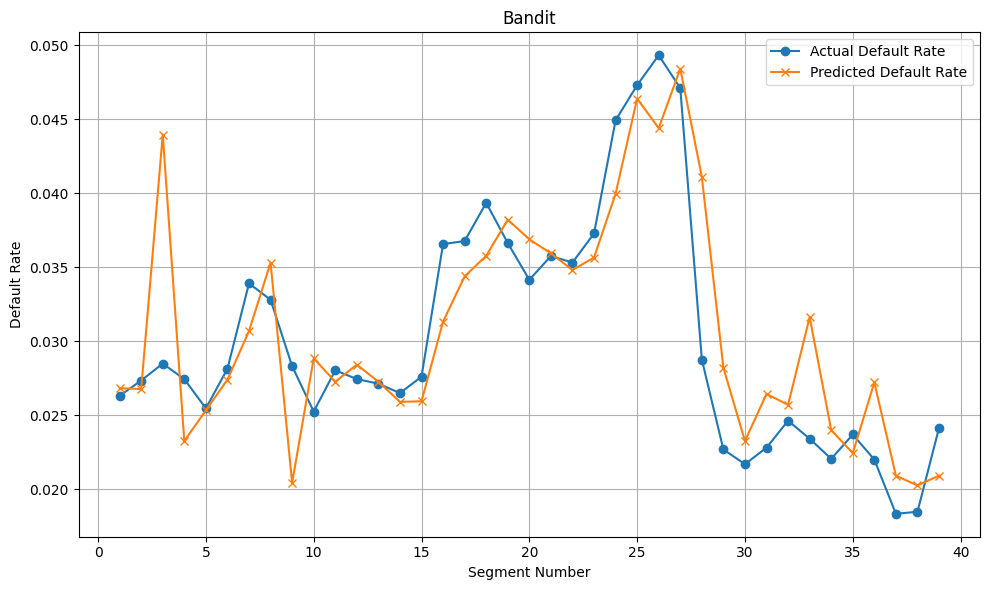

In [23]:
import matplotlib.pyplot as plt
bandit_eps_df = run_bandit_epsilon_greedy_n1(final_segments, threshold=0.03, epsilon=0.15)
df = bandit_eps_df.sort_values('segment_num')

plt.figure(figsize=(10, 6))
plt.plot(df['segment_num'], df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(df['segment_num'], df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title("Bandit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df

segment  segment_num               type       auc    recall  specificity  \
0    split_1            1  bandit_eps0.15_n1  0.649115  0.322398     0.835902   
1    split_2            2  bandit_eps0.15_n1  0.649952  0.366215     0.789894   
2    split_3            3  bandit_eps0.15_n1  0.623860  0.443276     0.724960   
3    split_4            4  bandit_eps0.15_n1  0.591231  0.355401     0.787314   
4    split_5            5  bandit_eps0.15_n1  0.622672  0.373522     0.782324   
5    split_6            6  bandit_eps0.15_n1  0.639603  0.434934     0.744864   
6    split_7            7  bandit_eps0.15_n1  0.641760  0.529231     0.668803   
7    split_8            8  bandit_eps0.15_n1  0.632986  0.632244     0.570172   
8    split_9            9  bandit_eps0.15_n1  0.598013  0.368060     0.765468   
9   split_10           10  bandit_eps0.15_n1  0.648373  0.495719     0.707094   
10  split_11           11  bandit_eps0.15_n1  0.636637  0.436207     0.742918   
11  split_12           12  bandit_eps0.15_n1  0.646859  0.470106     0.732644   
12  split_13           13  bandit_eps0.15_n1  0.647511  0.463900     0.727655   
13  split_14           14  bandit_eps0.15_n1  0.644321  0.412791     0.772201   
14  split_15           15  bandit_eps0.15_n1  0.648131  0.423574     0.752997   
15  split_16           16  bandit_eps0.15_n1  0.635253  0.528942     0.657776   
16  split_17           17  bandit_eps0.15_n1  0.632156  0.632789     0.555794   
17  split_18           18  bandit_eps0.15_n1  0.632648  0.629562     0.559341   
18  split_19           19  bandit_eps0.15_n1  0.630910  0.700360     0.484613   
19  split_20           20  bandit_eps0.15_n1  0.652566  0.736359     0.485115   
20  split_21           21  bandit_eps0.15_n1  0.620922  0.620273     0.569606   
21  split_22           22  bandit_eps0.15_n1  0.650758  0.699454     0.518060   
22  split_23           23  bandit_eps0.15_n1  0.646273  0.688366     0.521133   
23  split_24           24  bandit_eps0.15_n1  0.644710  0.711250     0.482123   
24  split_25           25  bandit_eps0.15_n1  0.640832  0.780645     0.408213   
25  split_26           26  bandit_eps0.15_n1  0.635674  0.806186     0.354609   
26  split_27           27  bandit_eps0.15_n1  0.642290  0.864555     0.273112   
27  split_28           28  bandit_eps0.15_n1  0.650603  0.751196     0.467394   
28  split_29           29  bandit_eps0.15_n1  0.675489  0.572816     0.719215   
29  split_30           30  bandit_eps0.15_n1  0.583865  0.333333     0.792149   
30  split_31           31  bandit_eps0.15_n1  0.637611  0.412533     0.773054   
31  split_32           32  bandit_eps0.15_n1  0.659123  0.487805     0.742388   
32  split_33           33  bandit_eps0.15_n1  0.673072  0.597035     0.664425   
33  split_34           34  bandit_eps0.15_n1  0.710050  0.488599     0.795752   
34  split_35           35  bandit_eps0.15_n1  0.668351  0.428571     0.787162   
35  split_36           36  bandit_eps0.15_n1  0.674693  0.504049     0.738437   
36  split_37           37  bandit_eps0.15_n1  0.677546  0.391453     0.847078   
37  split_38           38  bandit_eps0.15_n1  0.680247  0.398990     0.830997   
38  split_39           39  bandit_eps0.15_n1  0.681133  0.347357     0.849933   

    actual_default_rate  predicted_default_rate  accept_rate     tn     fp  \
0              0.026322                0.026836     0.831735  27334   5366   
1              0.027358                0.026782     0.785623  22775   6058   
2              0.028502                0.043970     0.720165  32890  12478   
3              0.027450                0.023271     0.783396  24017   6488   
4              0.025477                0.025346     0.778353  25316   7044   
5              0.028155                0.027414     0.739802  36946  12655   
6              0.033920                0.030702     0.662086  18572   9197   
7              0.032811                0.035314     0.563531  15950  12024   
8              0.028327                0.020445     0.761685  

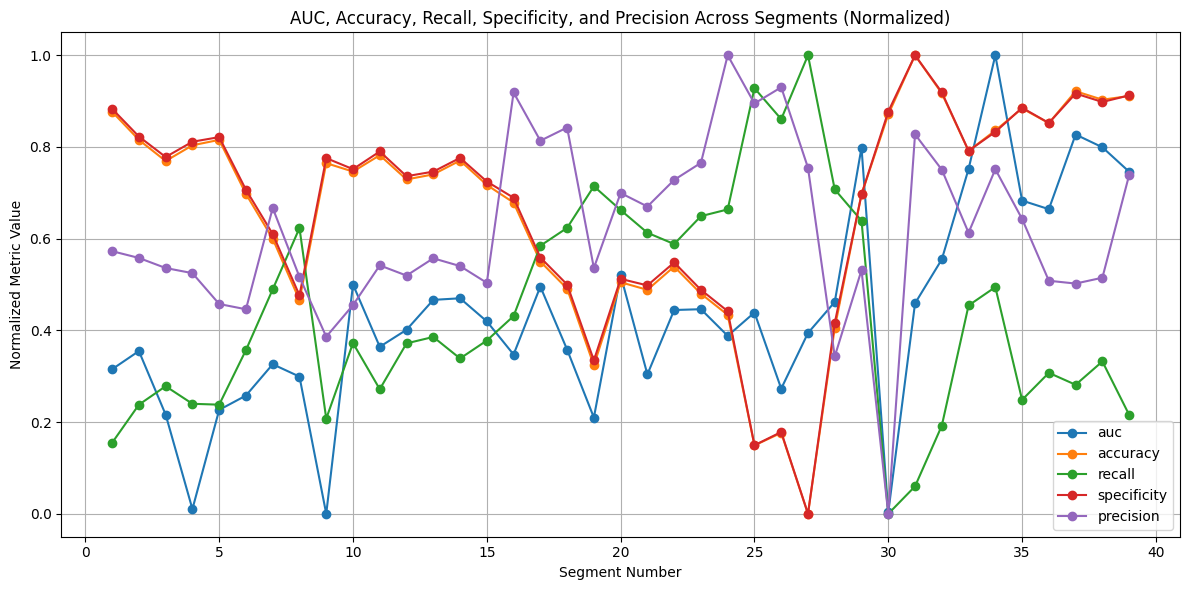

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Sort and copy the DataFrame
df = bandit_eps_df.sort_values('segment_num').copy()

# Step 2: Compute additional metrics
df['accuracy'] = (df['tp'] + df['tn']) / (df['tp'] + df['tn'] + df['fp'] + df['fn'])
df['precision'] = df['tp'] / (df['tp'] + df['fp']).replace(0, np.nan)
df['precision'] = df['precision'].fillna(0)  # or keep NaN if you prefer

# Step 3: Select metrics to plot
metrics = ['auc', 'accuracy', 'recall', 'specificity', 'precision']

# Step 4: Normalize metrics for fair comparison
df_norm = df.copy()
df_norm[metrics] = df[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Step 5: Plot
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(df['segment_num'], df_norm[metric], marker='o', label=metric)

plt.xlabel('Segment Number')
plt.ylabel('Normalized Metric Value')
plt.title('AUC, Accuracy, Recall, Specificity, and Precision Across Segments (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


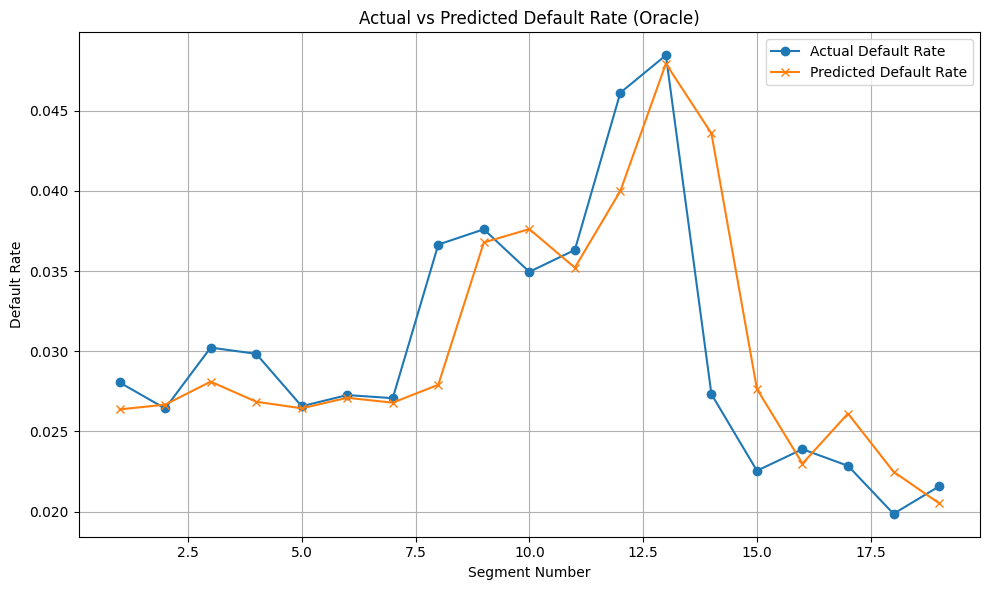

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    train_key = sorted_keys[t - 1]
    test_key = sorted_keys[t]

    # Prepare training and test data
    train_segment = final_segments[train_key]
    test_segment = final_segments[test_key]
    X_train_oracle = train_segment[features]
    y_train_oracle = train_segment["target"]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # Train Oracle model (full data)
    model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_oracle.fit(X_train_oracle, y_train_oracle)

    # Predict and evaluate
    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    accept_mask_oracle = y_pred_proba_oracle < 0.03

    results.append({
        "segment": test_key,
        "segment_num": int(test_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean(),
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    })

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt

# Filter Oracle results
oracle_df = results_df[results_df['type'] == 'oracle'].sort_values('segment_num')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(oracle_df['segment_num'], oracle_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(oracle_df['segment_num'], oracle_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Oracle)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
def run_oracle_with_n_splits(final_segments, n_previous_splits=2, threshold=0.03):
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    import pandas as pd

    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(n_previous_splits, len(sorted_keys)):
        train_keys = sorted_keys[t - n_previous_splits:t]
        test_key = sorted_keys[t]

        # Combine training data from the previous n splits
        X_train_list = []
        y_train_list = []
        for key in train_keys:
            segment = final_segments[key]
            X_train_list.append(segment[features])
            y_train_list.append(segment["target"])

        X_train_oracle = pd.concat(X_train_list, ignore_index=True)
        y_train_oracle = pd.concat(y_train_list, ignore_index=True)

        # Prepare test data
        test_segment = final_segments[test_key]
        X_test = test_segment[features]
        y_test = test_segment["target"]

        # Train model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train_oracle, y_train_oracle)

        # Predict and evaluate
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_pred_proba)
        accept_mask = y_pred_proba < threshold

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"oracle_{n_previous_splits}splits",
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_pred_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)



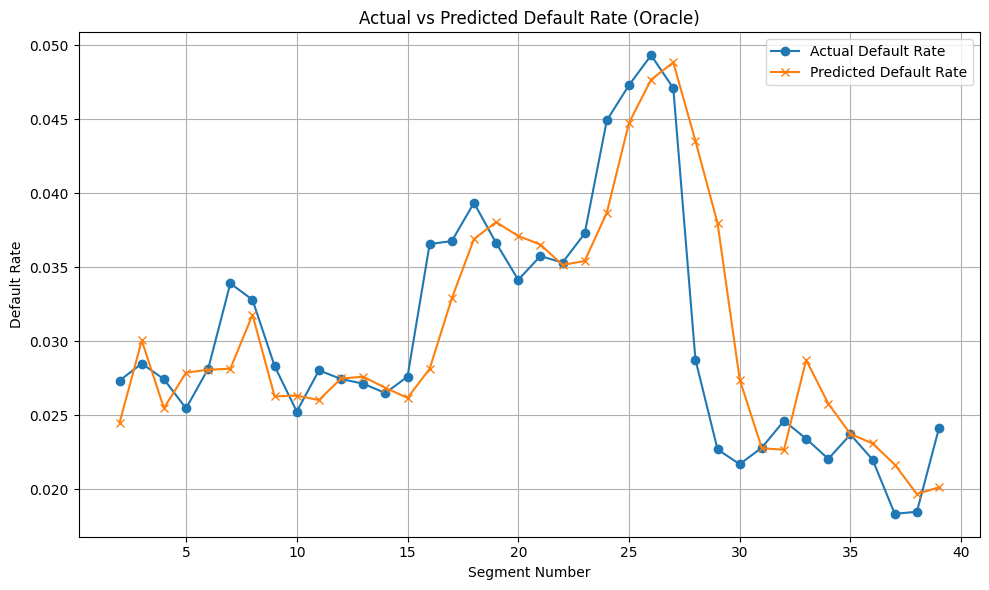

In [23]:
oracle_df = run_oracle_with_n_splits(final_segments, n_previous_splits=2)
oracle_df = oracle_df.sort_values('segment_num')
plt.figure(figsize=(10, 6))
plt.plot(oracle_df['segment_num'], oracle_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(oracle_df['segment_num'], oracle_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Oracle)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


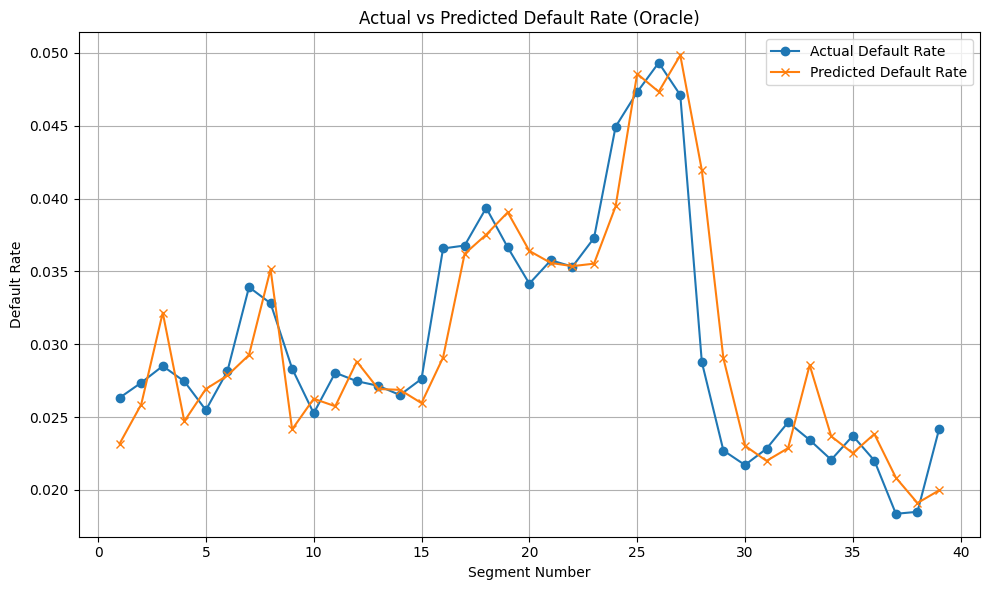

In [21]:
oracle_df = run_oracle_with_n_splits(final_segments, n_previous_splits=1)
oracle_df = oracle_df.sort_values('segment_num')
plt.figure(figsize=(10, 6))
plt.plot(oracle_df['segment_num'], oracle_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(oracle_df['segment_num'], oracle_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Oracle)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
def run_bandit_n1(final_segments, threshold=0.03):

    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    import pandas as pd

    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize training data using split_0
    X_train = final_segments[sorted_keys[0]][features]
    y_train = final_segments[sorted_keys[0]]['target']

    for t in range(1, len(sorted_keys)):
        test_key = sorted_keys[t]
        test_segment = final_segments[test_key]
        X_test = test_segment[features]
        y_test = test_segment['target']

        # Train model on approved applicants so far
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_pred_proba)
        accept_mask = y_pred_proba < threshold  # applicants predicted below threshold are approved

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": "bandit_n1",
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_pred_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Add only approved applicants to training set
        X_train = pd.concat([X_train, X_test[accept_mask]], ignore_index=True)
        y_train = pd.concat([y_train, y_test[accept_mask]], ignore_index=True)

    return pd.DataFrame(results)


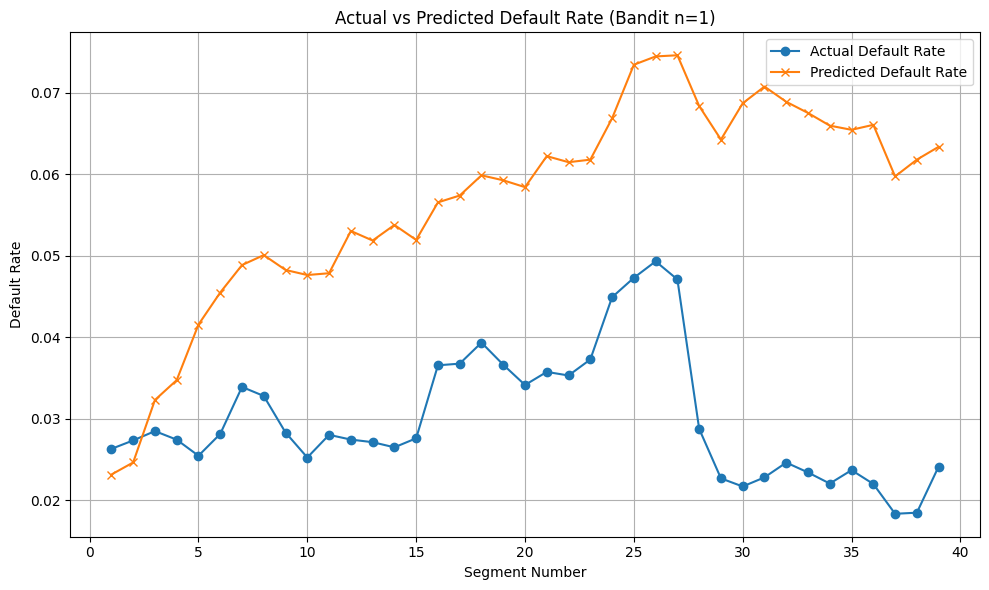

In [25]:
bandit_df = run_bandit_n1(final_segments, threshold=0.03)
bandit_df = bandit_df.sort_values("segment_num")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(bandit_df['segment_num'], bandit_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(bandit_df['segment_num'], bandit_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Bandit n=1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def approval_utility(y_true, y_pred_proba, threshold,
                     reward_approve_good, penalty_approve_bad):
    approve = y_pred_proba < threshold
    approve_good = ((approve == 1) & (y_true == 0)).sum()
    approve_bad = ((approve == 1) & (y_true == 1)).sum()

    return reward_approve_good * approve_good + penalty_approve_bad * approve_bad

def find_best_threshold(y_true, y_pred_proba, utility_func, **kwargs):
    thresholds = np.linspace(0.01, 0.99, 99)  
    best_threshold = 0.5
    best_utility = -np.inf

    for t in thresholds:
        u = utility_func(y_true, y_pred_proba, threshold=t, **kwargs)
        if u > best_utility:
            best_utility = u
            best_threshold = t

    return best_threshold, best_utility



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score, confusion_matrix

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT MODEL (only approved applicants) 
    model_bandit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_bandit.fit(X_train_bandit, y_train_bandit)

    y_pred_proba_bandit = model_bandit.predict_proba(X_test)[:, 1]
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)

    thresh_bandit = 0.03
    accept_mask_bandit = y_pred_proba_bandit < thresh_bandit
    y_pred_bandit = (y_pred_proba_bandit>=thresh_bandit).astype(int)
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)


    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Update bandit training data (only approved)
    X_train_bandit = pd.concat([X_train_bandit, X_test[accept_mask_bandit]], ignore_index=True)
    y_train_bandit = pd.concat([y_train_bandit, y_test[accept_mask_bandit]], ignore_index=True)

    # ORACLE MODEL (sees full data)
    model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_oracle.fit(X_train_oracle, y_train_oracle)

    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)


    thresh_oracle = 0.03
    accept_mask_oracle = y_pred_proba_oracle < thresh_oracle
    y_pred_oracle = (y_pred_proba_oracle>=thresh_oracle).astype(int)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)
    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Oracle adds all test applicants to training
    X_train_oracle = pd.concat([X_train_oracle, X_test], ignore_index=True)
    y_train_oracle = pd.concat([y_train_oracle, y_test], ignore_index=True)

results_df = pd.DataFrame(results)


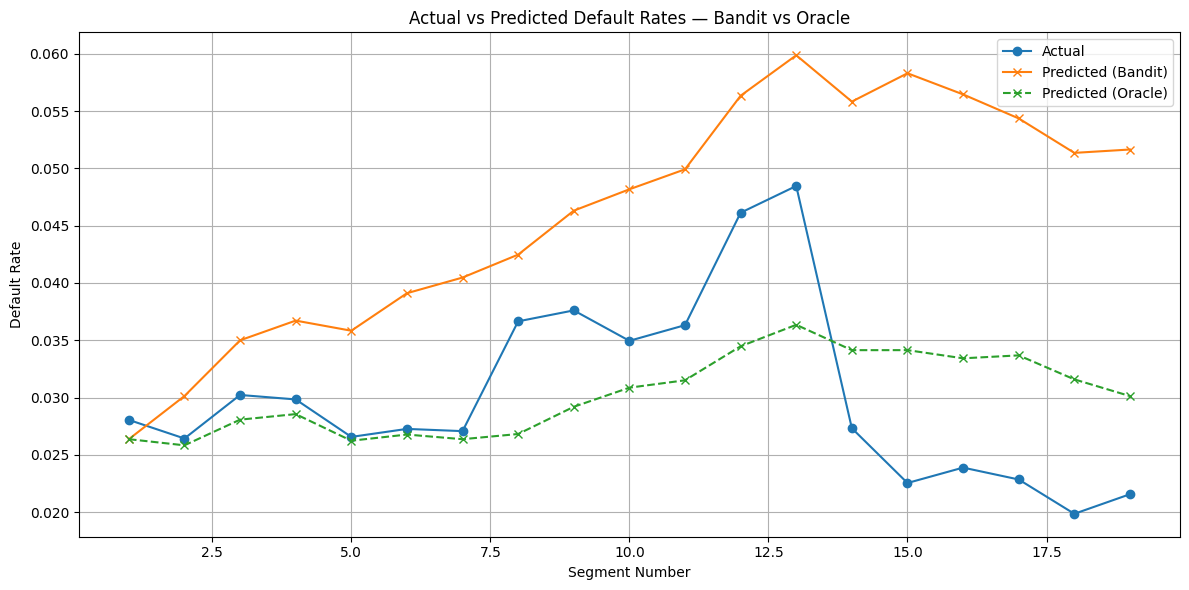

In [ ]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

# Bandit
plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')

# Oracle
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot2.pdf', format='pdf')
plt.show()


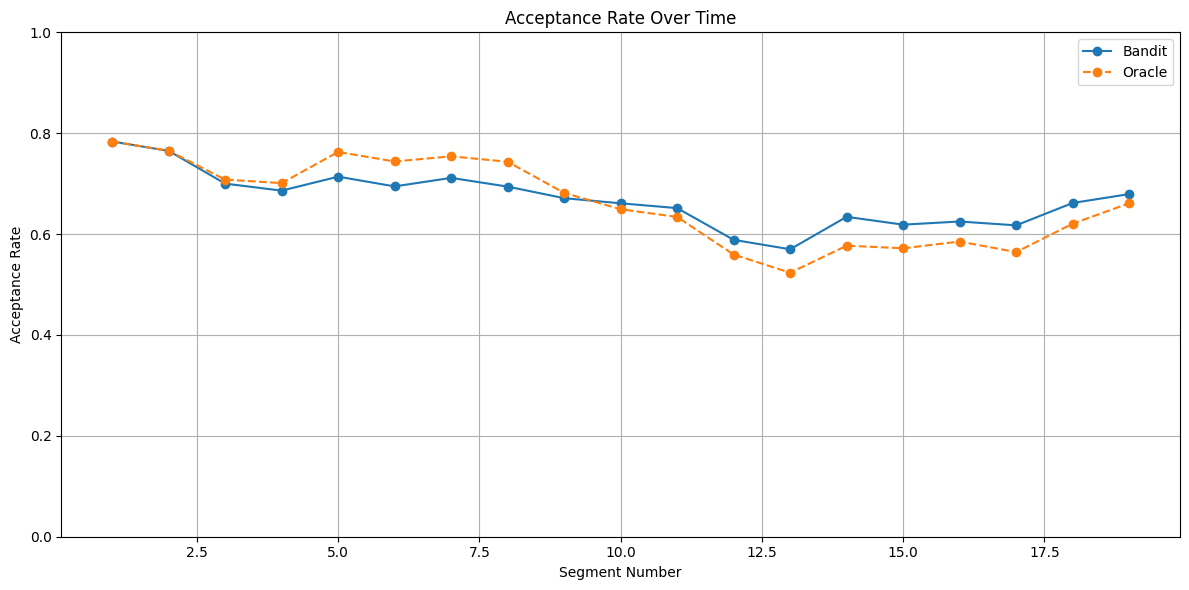

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bandit["segment_num"], df_bandit["accept_rate"], label="Bandit", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["accept_rate"], label="Oracle", marker='o', linestyle='--')

plt.title("Acceptance Rate Over Time")
plt.xlabel("Segment Number")
plt.ylabel("Acceptance Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Recall = $\frac{TP}{TP + FN}$ , Specificity = $\frac{TN}{TN + FP}$ 

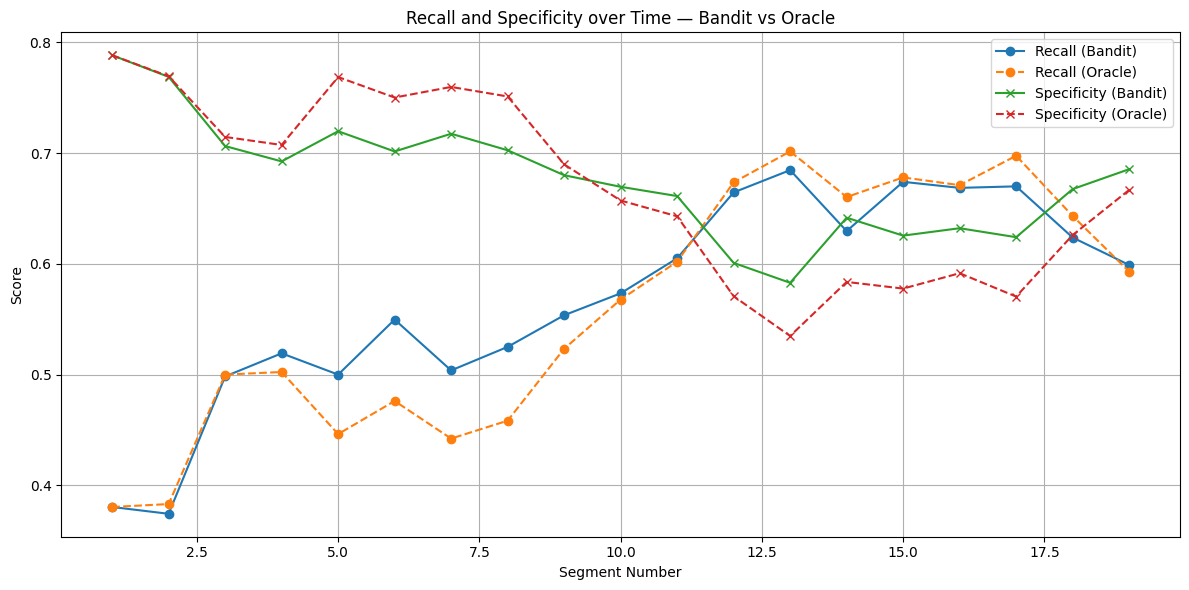

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_bandit["segment_num"], df_bandit["recall"], label="Recall (Bandit)", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["recall"], label="Recall (Oracle)", marker='o', linestyle='--')
plt.plot(df_bandit["segment_num"], df_bandit["specificity"], label="Specificity (Bandit)", marker='x')
plt.plot(df_oracle["segment_num"], df_oracle["specificity"], label="Specificity (Oracle)", marker='x', linestyle='--')
plt.xlabel("Segment Number")
plt.ylabel("Score")
plt.title("Recall and Specificity over Time — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot3.pdf', format='pdf')
plt.show()

# FN = Incorrectly accepted a defaulter, FP = Incorrectly rejected a non-defaulter
# TN = Accepted correctly, TP = Rejected correctly

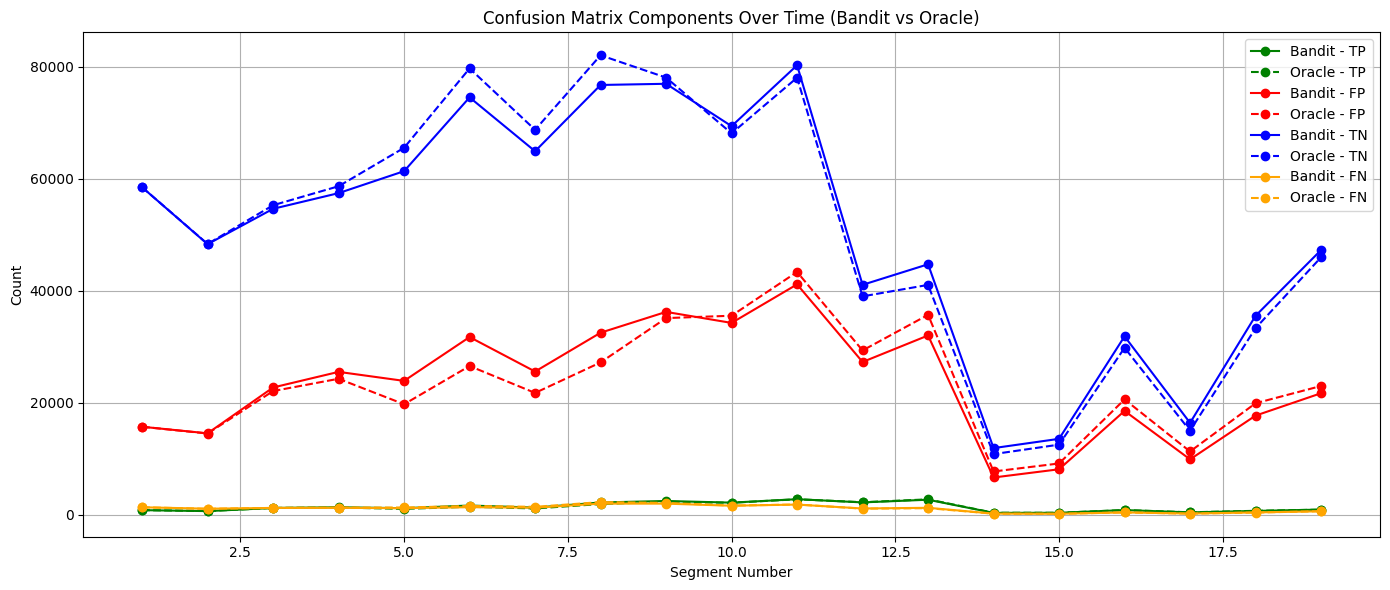

In [ ]:
plt.figure(figsize=(14, 6))
metrics = ["tp", "fp", "tn", "fn"]
colors = ["green", "red", "blue", "orange"]
styles = {"bandit": "-", "oracle": "--"}

for metric, color in zip(metrics, colors):
    for model_type in ["bandit", "oracle"]:
        df = results_df[results_df["type"] == model_type]
        label = f"{model_type.capitalize()} - {metric.upper()}"
        plt.plot(
            df["segment_num"],
            df[metric],
            linestyle=styles[model_type],
            color=color,
            marker='o',
            label=label
        )

plt.title("Confusion Matrix Components Over Time (Bandit vs Oracle)")
plt.xlabel("Segment Number")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df

segment  segment_num    type       auc    recall  specificity  \
0    split_1            1  bandit  0.632584  0.380486     0.788264   
1    split_1            1  oracle  0.632584  0.380486     0.788264   
2    split_2            2  bandit  0.610811  0.374341     0.768774   
3    split_2            2  oracle  0.623296  0.383128     0.769299   
4    split_3            3  bandit  0.650528  0.498342     0.706282   
5    split_3            3  oracle  0.648555  0.500000     0.714541   
6    split_4            4  bandit  0.653941  0.519201     0.692454   
7    split_4            4  oracle  0.648705  0.502351     0.707281   
8    split_5            5  bandit  0.666443  0.500000     0.719680   
9    split_5            5  oracle  0.661131  0.446306     0.768593   
10   split_6            6  bandit  0.676900  0.549664     0.701412   
11   split_6            6  oracle  0.666323  0.476174     0.750111   
12   split_7            7  bandit  0.664776  0.503771     0.717420   
13   split_7            7  oracle  0.651208  0.442239     0.759670   
14   split_8            8  bandit  0.670534  0.525012     0.702486   
15   split_8            8  oracle  0.655127  0.458393     0.751059   
16   split_9            9  bandit  0.669595  0.553571     0.679984   
17   split_9            9  oracle  0.653485  0.523282     0.689763   
18  split_10           10  bandit  0.674383  0.573369     0.669512   
19  split_10           10  oracle  0.659117  0.567776     0.657127   
20  split_11           11  bandit  0.683510  0.604981     0.661163   
21  split_11           11  oracle  0.668566  0.601923     0.642898   
22  split_12           12  bandit  0.680554  0.664448     0.600834   
23  split_12           12  oracle  0.668222  0.673525     0.570722   
24  split_13           13  bandit  0.682140  0.684574     0.582857   
25  split_13           13  oracle  0.665285  0.701458     0.534846   
26  split_14           14  bandit  0.691168  0.629559     0.641624   
27  split_14           14  oracle  0.680085  0.660269     0.583648   
28  split_15           15  bandit  0.704710  0.674000     0.625456   
29  split_15           15  oracle  0.677507  0.678000     0.577645   
30  split_16           16  bandit  0.703724  0.668558     0.632132   
31  split_16           16  oracle  0.679565  0.670989     0.591521   
32  split_17           17  bandit  0.709383  0.669919     0.624035   
33  split_17           17  oracle  0.687601  0.697561     0.570434   
34  split_18           18  bandit  0.709190  0.623726     0.667456   
35  split_18           18  oracle  0.686409  0.643188     0.625975   
36  split_19           19  bandit  0.704241  0.598948     0.685412   
37  split_19           19  oracle  0.680604  0.593031     0.666681   

    actual_default_rate  predicted_default_rate  accept_rate  
0              0.028058                0.026376     0.783530  
1              0.028058                0.026376     0.783530  
2              0.026436                0.030140     0.764991  
3              0.026436                0.025840     0.765270  
4              0.030232                0.035000     0.700095  
5              0.030232                0.028080     0.708054  
6              0.029844                0.036719     0.686138  
7              0.029844                0.028564     0.701024  
8              0.026575                0.035836     0.713842  
9              0.026575                0.026242     0.762882  
10             0.027273                0.039107     0.694565  
11             0.027273                0.026781     0.743939  
12             0.027078                0.040475     0.711431  
13             0.027078                0.026375     0.754203  
14             0.036655                0.042474     0.694147  
15             0.036655                0.026828     0.743382  
16             0.037609                0.046308     0.671201  
17             0.037609                0.029202     0.681751  
18             0.034955                0.048172     0.661022  
19            

Threshold not used: 0.9300
Predicted defaulters: 40802
Predicted non-defaulters: 35541
Max predicted probability: 0.9710
Threshold used: 0.0200
Threshold not used: 0.9500
Predicted defaulters: 36013
Predicted non-defaulters: 28559
Max predicted probability: 0.6811
Threshold used: 0.0200
Threshold not used: 0.9600
Predicted defaulters: 55119
Predicted non-defaulters: 24663
Max predicted probability: 0.8181
Threshold used: 0.0200
Threshold not used: 0.9800
Predicted defaulters: 57384
Predicted non-defaulters: 28128
Max predicted probability: 0.9274
Threshold used: 0.0200
Threshold not used: 0.9700
Predicted defaulters: 48027
Predicted non-defaulters: 39575
Max predicted probability: 1.0000
Threshold used: 0.0200
Threshold not used: 0.9900
Predicted defaulters: 62822
Predicted non-defaulters: 46445
Max predicted probability: 1.0000
Threshold used: 0.0200
Threshold not used: 0.9900
Predicted defaulters: 52443
Predicted non-defaulters: 40585
Max predicted probability: 0.7958
Threshold used:

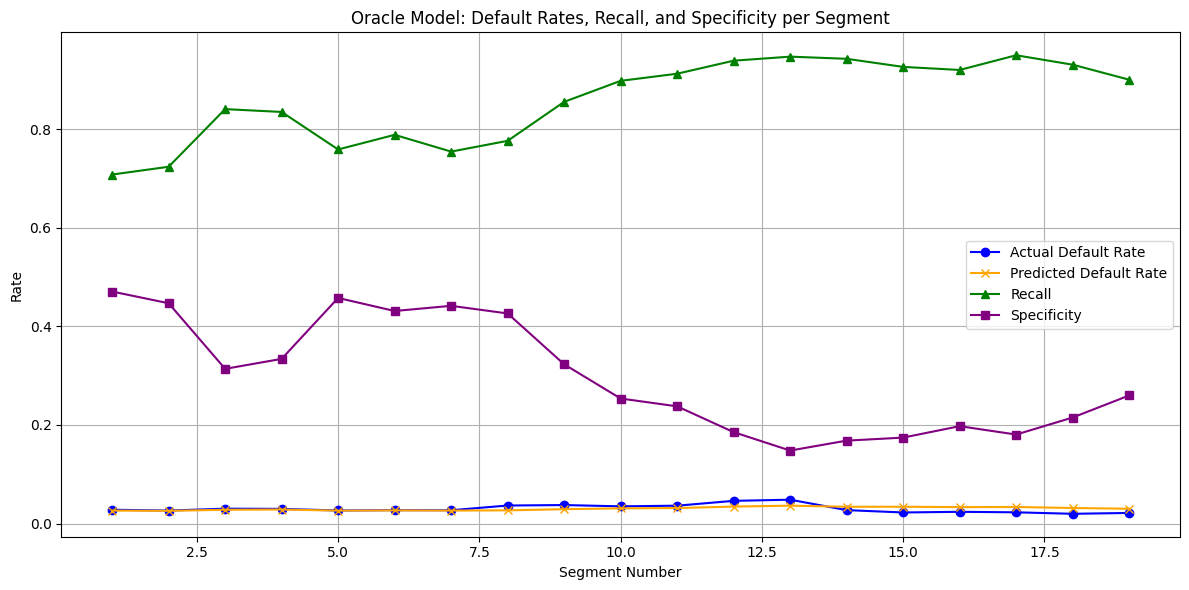

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# --- Helper functions ---

def compute_recall_specificity(y_true, y_pred_label):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_label).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    return recall, specificity

def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_threshold = 0.5
    best_utility = -np.inf
    for t in thresholds:
        approve = y_pred_proba < t
        approve_good = ((approve == 1) & (y_true == 0)).sum()
        approve_bad = ((approve == 1) & (y_true == 1)).sum()
        reject_good = ((approve == 0) & (y_true == 0)).sum()
        utility = 1 * approve_good + (-20000) * approve_bad -10000*reject_good
        if utility > best_utility:
            best_utility = utility
            best_threshold = t
    return best_threshold

# --- Setup ---

exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[1]))
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

# Initialize tracking lists
segment_nums, recalls, specificities, actual_rates, predicted_rates = [], [], [], [], []

# Start with initial training data
X_train = final_segments['split_0'][features]
y_train = final_segments['split_0']['target']

# Loop through test splits
for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # Train oracle model on all available data
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    predicted_rate = y_pred_proba.mean()
    actual_rate = y_test.mean()

    # Find best threshold using training data
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    best_thresh = find_best_threshold(y_train, y_pred_proba_train)
    print(f"Threshold not used: {best_thresh:.4f}")
    best_thresh = min(best_thresh, 0.02)
    # Compute recall and specificity at best threshold
    y_pred_label = (y_pred_proba >= best_thresh).astype(int)

    num_defaulters = y_pred_label.sum()
    num_non_defaulters = (y_pred_label == 0).sum()

    print(f"Predicted defaulters: {num_defaulters}")
    print(f"Predicted non-defaulters: {num_non_defaulters}")

    print(f"Max predicted probability: {y_pred_proba.max():.4f}")
    print(f"Threshold used: {best_thresh:.4f}")


    recall, specificity = compute_recall_specificity(y_test, y_pred_label)

    # Track results
    segment_nums.append(t)
    recalls.append(recall)
    specificities.append(specificity)
    actual_rates.append(actual_rate)
    predicted_rates.append(predicted_rate)

    # Oracle sees all of current test segment
    X_train = pd.concat([X_train, X_test], ignore_index=True)
    y_train = pd.concat([y_train, y_test], ignore_index=True)

# --- Plot all metrics ---

plt.figure(figsize=(12, 6))

plt.plot(segment_nums, actual_rates, marker='o', label="Actual Default Rate", color='blue')
plt.plot(segment_nums, predicted_rates, marker='x', label="Predicted Default Rate", color='orange')
plt.plot(segment_nums, recalls, marker='^', label="Recall", color='green')
plt.plot(segment_nums, specificities, marker='s', label="Specificity", color='purple')

plt.xlabel("Segment Number")
plt.ylabel("Rate")
plt.title("Oracle Model: Default Rates, Recall, and Specificity per Segment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


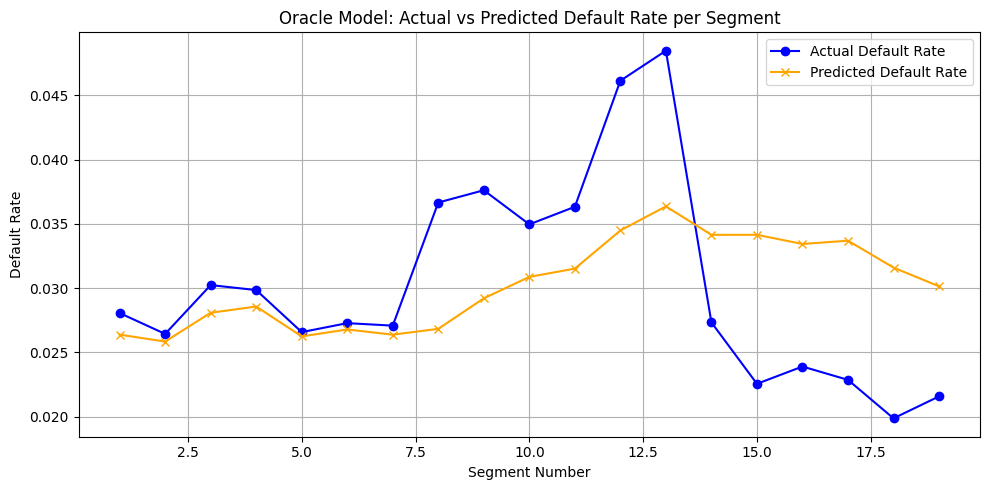

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(segment_nums, actual_rates, marker='o', label="Actual Default Rate", color='blue')
plt.plot(segment_nums, predicted_rates, marker='x', label="Predicted Default Rate", color='orange')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Oracle Model: Actual vs Predicted Default Rate per Segment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

# Define the SGD model (online logistic regression)
model_bandit = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
)
model_oracle = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
)

# Initial fit (important for setting up internal parameters)
model_bandit.fit(X_train_bandit, y_train_bandit)
model_oracle.fit(X_train_oracle, y_train_oracle)

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT
    y_pred_proba_bandit = model_bandit.predict_proba(X_test)[:, 1]
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)
    y_pred_bandit = (y_pred_proba_bandit >= 0.03).astype(int)
    accept_mask_bandit = y_pred_proba_bandit < 0.03
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean()
    })

    # Update bandit with only accepted applicants
    if accept_mask_bandit.any():
        model_bandit.named_steps['sgdclassifier'].partial_fit(
            StandardScaler().fit_transform(X_test[accept_mask_bandit]), 
            y_test[accept_mask_bandit], 
            classes=[0, 1]
        )

    # ORACLE
    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    accept_mask_oracle = y_pred_proba_oracle < 0.03
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean()
    })

    # Update oracle with full test data
    model_oracle.named_steps['sgdclassifier'].partial_fit(
        StandardScaler().fit_transform(X_test),
        y_test,
        classes=[0, 1]
    )

results_df = pd.DataFrame(results)


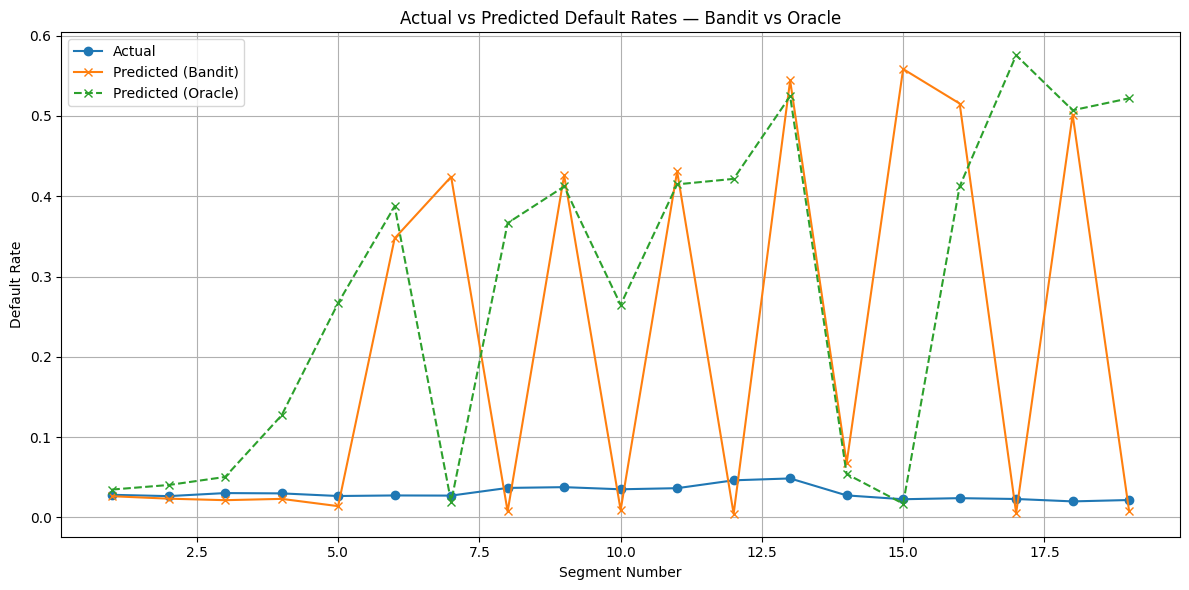

In [ ]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

# Bandit
plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')

# Oracle
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot4.pdf', format='pdf')
plt.show()

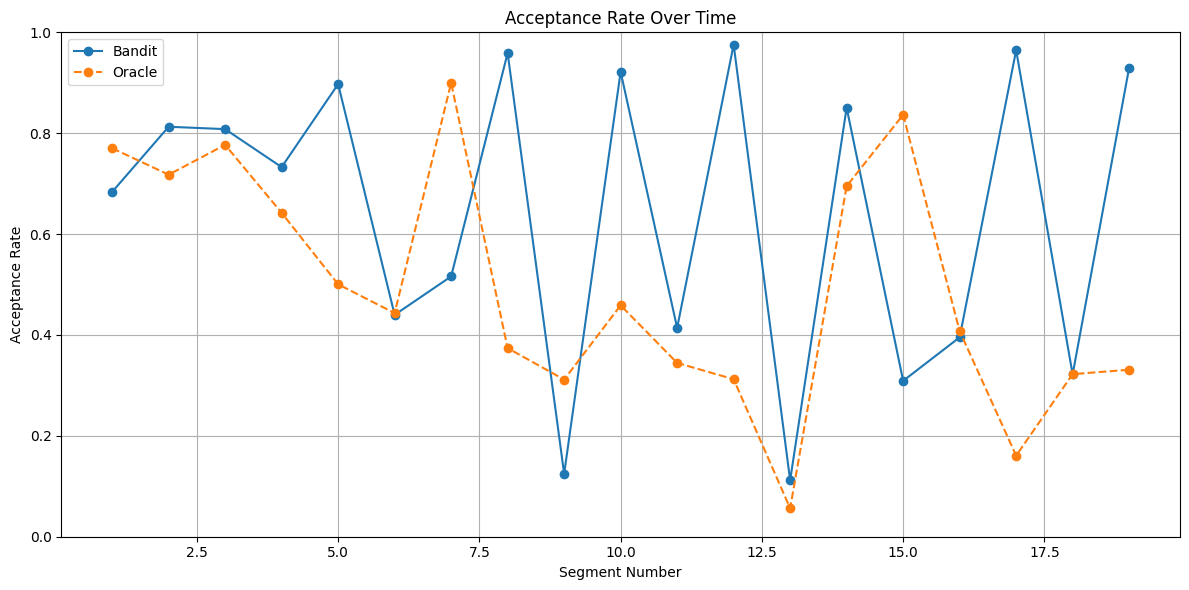

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bandit["segment_num"], df_bandit["accept_rate"], label="Bandit", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["accept_rate"], label="Oracle", marker='o', linestyle='--')

plt.title("Acceptance Rate Over Time")
plt.xlabel("Segment Number")
plt.ylabel("Acceptance Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df

segment  segment_num    type       auc    recall  specificity  \
0    split_1            1  bandit  0.490278  0.315126     0.683549   
1    split_1            1  oracle  0.557704  0.315593     0.772698   
2    split_2            2  bandit  0.544128  0.281781     0.815366   
3    split_2            2  oracle  0.578368  0.400703     0.720974   
4    split_3            3  bandit  0.542545  0.262023     0.810288   
5    split_3            3  oracle  0.566859  0.342040     0.780626   
6    split_4            4  bandit  0.487967  0.290752     0.733474   
7    split_4            4  oracle  0.636290  0.542712     0.647842   
8    split_5            5  bandit  0.436214  0.153351     0.898726   
9    split_5            5  oracle  0.675697  0.752148     0.507353   
10   split_6            6  bandit  0.638316  0.736577     0.444824   
11   split_6            6  oracle  0.623437  0.714765     0.447741   
12   split_7            7  bandit  0.624235  0.623660     0.519915   
13   split_7            7  oracle  0.397347  0.110361     0.899911   
14   split_8            8  bandit  0.412684  0.066859     0.959974   
15   split_8            8  oracle  0.635714  0.783069     0.379853   
16   split_9            9  bandit  0.624389  0.889241     0.125195   
17   split_9            9  oracle  0.632911  0.829114     0.317065   
18  split_10           10  bandit  0.408278  0.116112     0.923149   
19  split_10           10  oracle  0.665819  0.768309     0.466923   
20  split_11           11  bandit  0.651895  0.785449     0.421432   
21  split_11           11  oracle  0.641590  0.830675     0.351189   
22  split_12           12  bandit  0.378719  0.026021     0.975887   
23  split_12           12  oracle  0.667628  0.884418     0.321721   
24  split_13           13  bandit  0.648323  0.953185     0.115031   
25  split_13           13  oracle  0.645900  0.971604     0.057783   
26  split_14           14  bandit  0.600129  0.285988     0.854385   
27  split_14           14  oracle  0.400470  0.282150     0.694423   
28  split_15           15  bandit  0.651458  0.868000     0.313120   
29  split_15           15  oracle  0.379383  0.164000     0.836633   
30  split_16           16  bandit  0.657336  0.794165     0.399948   
31  split_16           16  oracle  0.680764  0.817666     0.413221   
32  split_17           17  bandit  0.391571  0.071545     0.965382   
33  split_17           17  oracle  0.654005  0.925203     0.162780   
34  split_18           18  bandit  0.662951  0.858202     0.325387   
35  split_18           18  oracle  0.672795  0.854495     0.325950   
36  split_19           19  bandit  0.373135  0.067719     0.929874   
37  split_19           19  oracle  0.664742  0.852071     0.335102   

    actual_default_rate  predicted_default_rate  accept_rate  
0              0.028058                0.026308     0.683586  
1              0.028058                0.034622     0.770221  
2              0.026436                0.023265     0.812798  
3              0.026436                0.040289     0.717757  
4              0.030232                0.021375     0.808102  
5              0.030232                0.050310     0.776917  
6              0.029844                0.023013     0.732751  
7              0.029844                0.127132     0.642155  
8              0.026575                0.013943     0.897343  
9              0.026575                0.266930     0.500457  
10             0.027273                0.347540     0.439877  
11             0.027273                0.387505     0.443309  
12             0.027078                0.424238     0.516027  
13             0.027078                0.019236     0.899632  
14             0.036655                0.007355     0.958990  
15             0.036655                0.366584     0.373882  
16             0.037609                0.426089     0.124653  
17             0.037609                0.412160     0.311568  
18             0.034955                0.009131     0.921777  
19            

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []

exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

# Define scalers and classifiers
scaler_bandit = StandardScaler()
scaler_oracle = StandardScaler()

clf_bandit = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
clf_oracle = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)

# Initial fit (scaler + classifier)
X_bandit_scaled = scaler_bandit.fit_transform(X_train_bandit)
X_oracle_scaled = scaler_oracle.fit_transform(X_train_oracle)

clf_bandit.partial_fit(X_bandit_scaled, y_train_bandit, classes=[0, 1])
clf_oracle.partial_fit(X_oracle_scaled, y_train_oracle, classes=[0, 1])

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT
    scaler_bandit.partial_fit(X_test)  # update running mean/var
    X_test_scaled_bandit = scaler_bandit.transform(X_test)

    y_pred_proba_bandit = clf_bandit.predict_proba(X_test_scaled_bandit)[:, 1]
    y_pred_bandit = (y_pred_proba_bandit >= 0.03).astype(int)
    accept_mask_bandit = y_pred_proba_bandit < 0.03
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Update bandit model only with accepted applicants
    if accept_mask_bandit.any():
        clf_bandit.partial_fit(
            X_test_scaled_bandit[accept_mask_bandit],
            y_test[accept_mask_bandit],
            classes=[0, 1]
        )

    # ORACLE 
    scaler_oracle.partial_fit(X_test)  # update running mean/var
    X_test_scaled_oracle = scaler_oracle.transform(X_test)

    y_pred_proba_oracle = clf_oracle.predict_proba(X_test_scaled_oracle)[:, 1]
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    accept_mask_oracle = y_pred_proba_oracle < 0.03
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Update oracle model with all data
    clf_oracle.partial_fit(
        X_test_scaled_oracle,
        y_test,
        classes=[0, 1]
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)


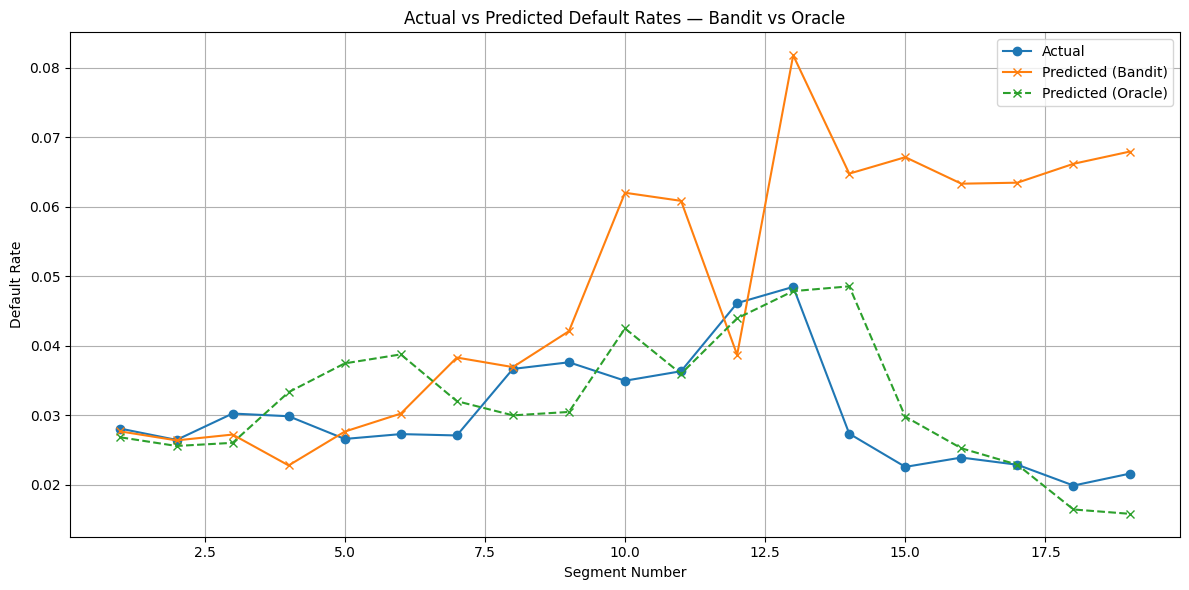

In [ ]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot5.pdf', format='pdf')
plt.show()

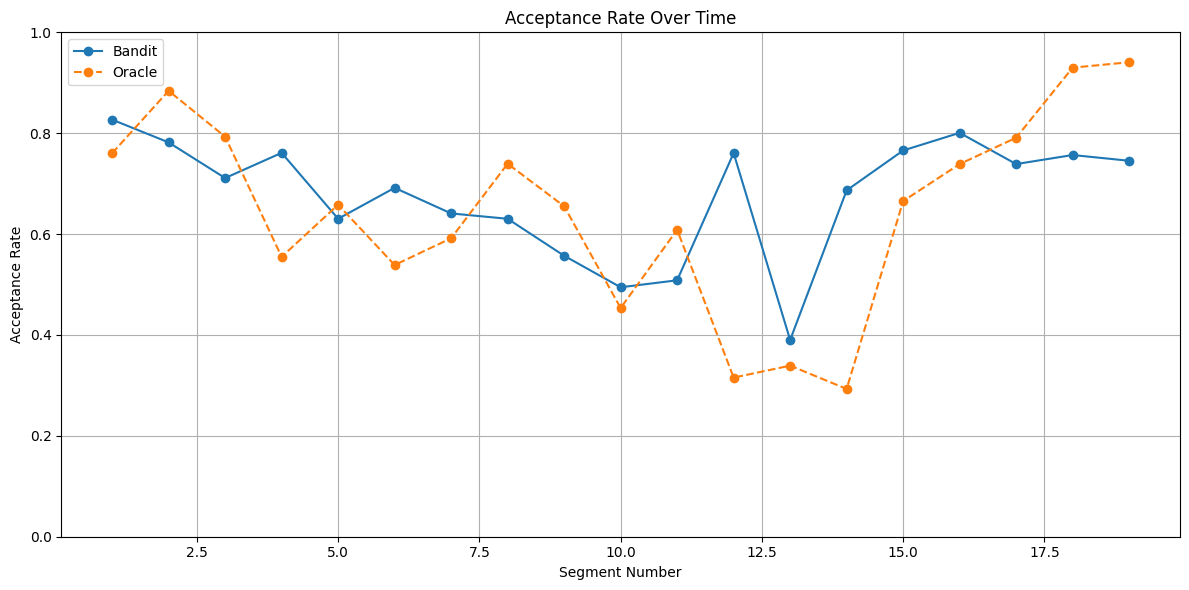

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bandit["segment_num"], df_bandit["accept_rate"], label="Bandit", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["accept_rate"], label="Oracle", marker='o', linestyle='--')

plt.title("Acceptance Rate Over Time")
plt.xlabel("Segment Number")
plt.ylabel("Acceptance Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

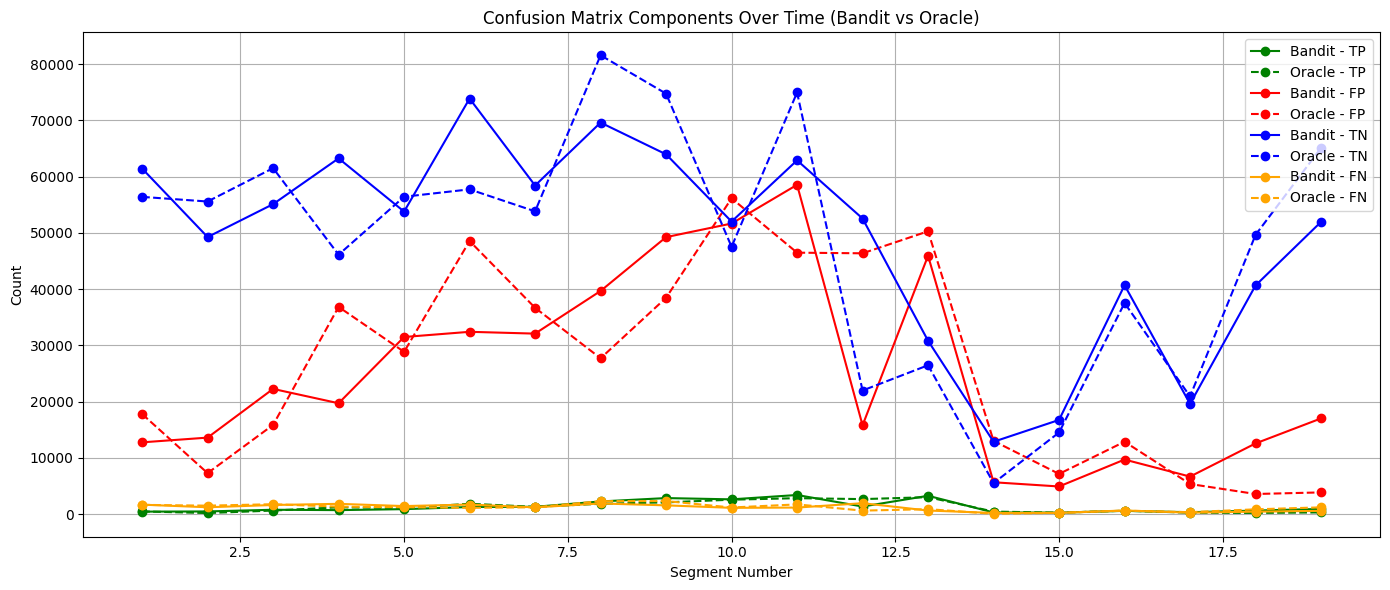

In [ ]:
plt.figure(figsize=(14, 6))
metrics = ["tp", "fp", "tn", "fn"]
colors = ["green", "red", "blue", "orange"]
styles = {"bandit": "-", "oracle": "--"}

for metric, color in zip(metrics, colors):
    for model_type in ["bandit", "oracle"]:
        df = results_df[results_df["type"] == model_type]
        label = f"{model_type.capitalize()} - {metric.upper()}"
        plt.plot(
            df["segment_num"],
            df[metric],
            linestyle=styles[model_type],
            color=color,
            marker='o',
            label=label
        )

plt.title("Confusion Matrix Components Over Time (Bandit vs Oracle)")
plt.xlabel("Segment Number")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df

segment  segment_num    type       auc    recall  specificity  \
0    split_1            1  bandit  0.475615  0.210084     0.827954   
1    split_1            1  oracle  0.458247  0.228291     0.760084   
2    split_2            2  bandit  0.530646  0.282953     0.783536   
3    split_2            2  oracle  0.446963  0.114236     0.884005   
4    split_3            3  bandit  0.518444  0.324627     0.712227   
5    split_3            3  oracle  0.541130  0.266169     0.794933   
6    split_4            4  bandit  0.515711  0.280956     0.762355   
7    split_4            4  oracle  0.514518  0.478840     0.555894   
8    split_5            5  bandit  0.474576  0.382732     0.630720   
9    split_5            5  oracle  0.590761  0.468213     0.661655   
10   split_6            6  bandit  0.577259  0.426174     0.695033   
11   split_6            6  oracle  0.624273  0.622148     0.543190   
12   split_7            7  bandit  0.625573  0.520445     0.645439   
13   split_7            7  oracle  0.581197  0.516078     0.594736   
14   split_8            8  bandit  0.612672  0.543050     0.636948   
15   split_8            8  oracle  0.643841  0.443963     0.746447   
16   split_9            9  bandit  0.649353  0.646248     0.565009   
17   split_9            9  oracle  0.591424  0.474458     0.660268   
18  split_10           10  bandit  0.651880  0.700932     0.501649   
19  split_10           10  oracle  0.606459  0.684687     0.458435   
20  split_11           11  bandit  0.686014  0.744156     0.517902   
21  split_11           11  oracle  0.657131  0.620931     0.617230   
22  split_12           12  bandit  0.640049  0.410287     0.768922   
23  split_12           12  oracle  0.617264  0.809682     0.321560   
24  split_13           13  bandit  0.686255  0.835508     0.401522   
25  split_13           13  oracle  0.610952  0.772832     0.344873   
26  split_14           14  bandit  0.689055  0.581574     0.694208   
27  split_14           14  oracle  0.668752  0.875240     0.297756   
28  split_15           15  bandit  0.710425  0.544000     0.772901   
29  split_15           15  oracle  0.631020  0.530000     0.669943   
30  split_16           16  bandit  0.715422  0.473258     0.807456   
31  split_16           16  oracle  0.663907  0.494327     0.744524   
32  split_17           17  bandit  0.730835  0.564228     0.745920   
33  split_17           17  oracle  0.685383  0.421138     0.796021   
34  split_18           18  bandit  0.750184  0.587581     0.763757   
35  split_18           18  oracle  0.696452  0.202966     0.932668   
36  split_19           19  bandit  0.745822  0.612755     0.753248   
37  split_19           19  oracle  0.696843  0.204471     0.943923   

    actual_default_rate  predicted_default_rate  accept_rate     tn     fp  \
0              0.028058                0.027657     0.826887  61435  12766   
1              0.028058                0.026807     0.760410  56399  17802   
2              0.026436                0.026368     0.781778  49257  13608   
3              0.026436                0.025564     0.884052  55573   7292   
4              0.030232                0.027206     0.711113  55105  22265   
5              0.030232                0.026014     0.793086  61504  15866   
6              0.029844                0.022763     0.761063  63245  19715   
7              0.029844                0.033312     0.554858  46117  36843   
8              0.026575                0.027633     0.630362  53784  31490   
9              0.026575                0.037452     0.658204  56422  28852   
10             0.027273                0.030222     0.691728  73873  32414   
11             0.027273                0.038743     0.538680  57734  48553   
12             0.027078                0.038290     0.640947  58418  32091   
13             0.027078                0.032013     0.591736  53829  36680   
14             0.036655                0.036916     0.630350  69605  39674   
15             0.036655   

# Threshold 

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

# utility function 
def utility(tp, tn, fp, fn):
    #return tp * 5000 + tn * 100 - fp * 200 - fn * 500
    return tp * 10000 + tn * 500 - fp * 200 - fn * 5000

def run_oracle_with_utility_threshold(final_segments, n_previous_splits=1, thresholds=np.linspace(0.01, 0.3, 40)):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(n_previous_splits, len(sorted_keys)):
        train_keys = sorted_keys[t - n_previous_splits:t]
        test_key = sorted_keys[t]

        # Combine training data
        X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
        y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)

        # Test data
        test_segment = final_segments[test_key]
        X_test = test_segment[features]
        y_test = test_segment["target"]

        # Fit model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Predict probabilities
        y_proba = model.predict_proba(X_test)[:, 1]

        # Find threshold with highest utility
        best_util = -np.inf
        best_threshold = None
        best_stats = {}

        for th in thresholds:
            y_pred = (y_proba >= th).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            util = utility(tp, tn, fp, fn)
            if util > best_util:
                best_util = util
                best_threshold = th
                best_stats = {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}

        # Compute final metrics
        tp = best_stats['tp']
        tn = best_stats['tn']
        fp = best_stats['fp']
        fn = best_stats['fn']
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        auc = roc_auc_score(y_test, y_proba)
        accept_rate = (y_proba < best_threshold).mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"oracle_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": best_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_proba.mean(),
            "accept_rate": accept_rate,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)


In [24]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix

def utility(tp, tn, fp, fn):
    #return tp * 10 + tn * 50 - fp * 200 - fn * 5000
    return 50*tp - 100*fn - fp * 5

def run_oracle_with_utility_threshold(final_segments, n_previous_splits=1, thresholds=np.linspace(0.01, 0.3, 40)):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(n_previous_splits, len(sorted_keys)):
        train_keys = sorted_keys[t - n_previous_splits:t]
        test_key = sorted_keys[t]

        # Prepare training data
        X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
        y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)

        # Prepare test data
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Train model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Learn best threshold from training set
        y_train_proba = model.predict_proba(X_train)[:, 1]
        best_util = -np.inf
        best_threshold = None 

        for th in thresholds:
            y_train_pred = (y_train_proba >= th).astype(int)
            tn_, fp_, fn_, tp_ = confusion_matrix(y_train, y_train_pred).ravel()
            trial_util = utility(tp_, tn_, fp_, fn_)
            if trial_util > best_util:
                best_util = trial_util
                best_threshold = th


        th = best_threshold

        # Predict on test set using chosen threshold
        y_test_proba = model.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Compute metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = (y_test_proba < th).mean()

        # Store results
        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"realistic_util_{n_previous_splits}splits",
            "threshold": th,
            "utility": utility(tp, tn, fp, fn),
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)



In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

def utility(tp, tn, fp, fn):
    #return 50*tp - 100*fn - fp * 5
    return 500*tp - 10*fn - fp * 50

def find_best_threshold(y_true, y_proba, thresholds):
    """Find the best threshold based on utility function"""
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        
        # Handle edge case where all predictions are the same class
        if len(np.unique(y_pred)) < 2:
            continue
            
        try:
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            trial_util = utility(tp, tn, fp, fn)
            
            if trial_util > best_util:
                best_util = trial_util
                best_threshold = th
        except ValueError:
            # Skip if confusion matrix can't be computed
            continue
    
    return best_threshold, best_util

def run_oracle_with_utility_threshold(final_segments, n_previous_splits=1, 
                                    thresholds=np.linspace(0.01, 0.3, 40),
                                    val_size=0.2, random_state=42):

    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
    
    for t in range(n_previous_splits, len(sorted_keys)):
        train_keys = sorted_keys[t - n_previous_splits:t]
        test_key = sorted_keys[t]
        
        # Prepare training data
        X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
        y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)
        
        # Prepare test data
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']
        
        # Split training data into fit/validation sets
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size, 
            random_state=random_state, stratify=y_train
        )
        
        # Train model on fitting set
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        model.fit(X_train_fit, y_train_fit)
        
        # Learn best threshold on validation set
        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)
        
        # If no valid threshold found, use default
        if best_threshold is None:
            best_threshold = 0.5
            print(f"Warning: No valid threshold found for {test_key}, using default 0.5")
        
        # Retrain model on full training set
        #model.fit(X_train, y_train)
        
        # Predict on test set using learned threshold
        y_test_proba = model.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_proba >= best_threshold).astype(int)
        
        # Compute confusion matrix and metrics
        try:
            tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        except ValueError:
            # Handle edge case where test set has only one class
            if y_test.sum() == 0:  # All negatives
                tn, fp, fn, tp = len(y_test) - y_test_pred.sum(), y_test_pred.sum(), 0, 0
            else:  # All positives
                tn, fp, fn, tp = 0, 0, len(y_test) - y_test_pred.sum(), y_test_pred.sum()
        
        # Compute metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        try:
            auc = roc_auc_score(y_test, y_test_proba)
        except ValueError:
            auc = 0.5  # Default AUC when only one class present
        
        accept_rate = (y_test_proba < best_threshold).mean()
        
        # Store results
        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"realistic_util_{n_previous_splits}splits_val",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "f1": f1,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })
    
    return pd.DataFrame(results)

In [47]:
oracle_df = run_oracle_with_utility_threshold(final_segments, n_previous_splits=1)


In [48]:
oracle_df

segment  segment_num                        type  threshold  utility  \
0    split_1            1  realistic_util_1splits_val   0.114103    -9740   
1    split_2            2  realistic_util_1splits_val   0.158718    -8280   
2    split_3            3  realistic_util_1splits_val   0.084359   -83560   
3    split_4            4  realistic_util_1splits_val   0.084359   -12020   
4    split_5            5  realistic_util_1splits_val   0.054615   -28110   
5    split_6            6  realistic_util_1splits_val   0.091795    -6760   
6    split_7            7  realistic_util_1splits_val   0.084359    -5940   
7    split_8            8  realistic_util_1splits_val   0.084359    -3040   
8    split_9            9  realistic_util_1splits_val   0.114103   -16910   
9   split_10           10  realistic_util_1splits_val   0.285128   -12370   
10  split_11           11  realistic_util_1splits_val   0.188462   -11180   
11  split_12           12  realistic_util_1splits_val   0.099231   -11770   
12  split_13           13  realistic_util_1splits_val   0.121538   -16680   
13  split_14           14  realistic_util_1splits_val   0.106667   -12030   
14  split_15           15  realistic_util_1splits_val   0.084359   -18700   
15  split_16           16  realistic_util_1splits_val   0.114103   -19680   
16  split_17           17  realistic_util_1splits_val   0.076923   -16750   
17  split_18           18  realistic_util_1splits_val   0.099231    -6740   
18  split_19           19  realistic_util_1splits_val   0.099231   -27330   
19  split_20           20  realistic_util_1splits_val   0.143846   -15820   
20  split_21           21  realistic_util_1splits_val   0.076923   -36450   
21  split_22           22  realistic_util_1splits_val   0.099231    -4940   
22  split_23           23  realistic_util_1splits_val   0.106667   -10580   
23  split_24           24  realistic_util_1splits_val   0.114103    -4260   
24  split_25           25  realistic_util_1splits_val   0.084359      170   
25  split_26           26  realistic_util_1splits_val   0.106667     1590   
26  split_27           27  realistic_util_1splits_val   0.084359      300   
27  split_28           28  realistic_util_1splits_val   0.076923    -7380   
28  split_29           29  realistic_util_1splits_val   0.277692     -770   
29  split_30           30  realistic_util_1splits_val   0.158718    -1050   
30  split_31           31  realistic_util_1splits_val   0.099231    -8080   
31  split_32           32  realistic_util_1splits_val   0.143846    -4900   
32  split_33           33  realistic_util_1splits_val   0.076923   -17520   
33  split_34           34  realistic_util_1splits_val   0.210769    -2400   
34  split_35           35  realistic_util_1splits_val   0.069487    -4550   
35  split_36           36  realistic_util_1splits_val   0.181026    -4600   
36  split_37           37  realistic_util_1splits_val   0.128974    -6310   
37  split_38           38  realistic_util_1splits_val   0.128974    -6160   
38  split_39           39  realistic_util_1splits_val   0.143846    -9060   

    validation_utility       auc    recall  specificity  precision        f1  \
0                -1630  0.632609  0.005656     0.997890   0.067568  0.010438   
1                -1760  0.632747  0.003699     0.998821   0.081081  0.007075   
2                 -290  0.617775  0.131480     0.929686   0.052006  0.074532   
3                -1260  0.600655  0.027875     0.989739   0.071217  0.040067   
4                -1680  0.621792  0.100473     0.961063   0.063197  0.077590   
5                  330  0.608432  0.028532     0.994637   0.133550  0.047018   
6                 -470  0.643912  0.047179     0.985848   0.104784  0.065064   
7                  780  0.629178  0.063224     0.982734   0.110497  0.080429   
8                -1270  0.602316  0.007486     0.997454   0.078947  0.013675   
9                -3460  0.649323  0.000856     0.999467   0.040000  0.001676   
10               -2440  0.628848  0.001724  

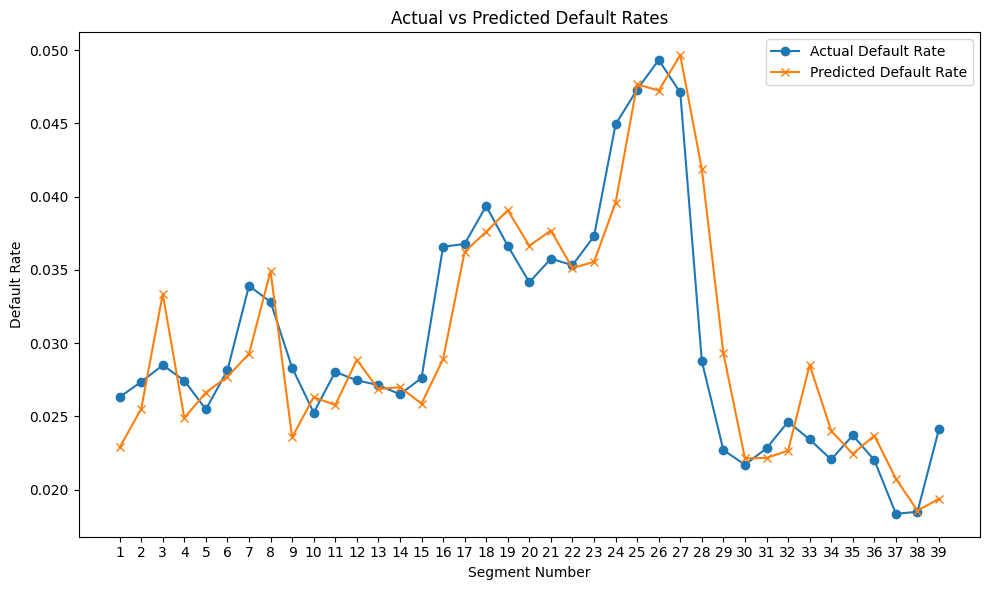

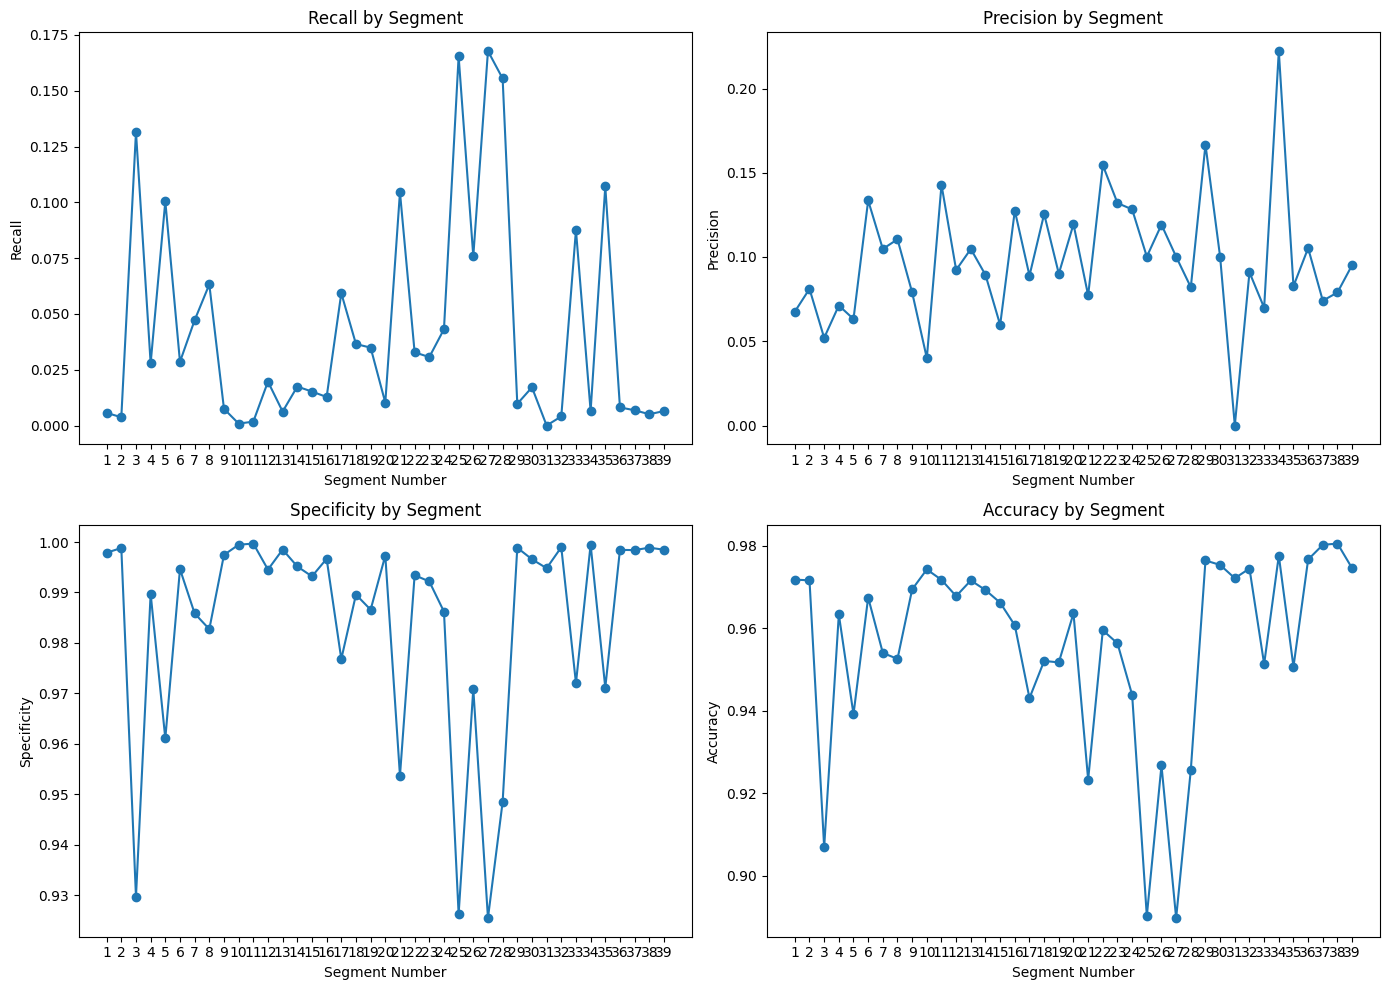

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

oracle_df["accuracy"] = (oracle_df["tp"] + oracle_df["tn"]) / (
    oracle_df["tp"] + oracle_df["tn"] + oracle_df["fp"] + oracle_df["fn"]
)
oracle_df["precision"] = oracle_df["tp"] / (oracle_df["tp"] + oracle_df["fp"])

# Sort by segment_num for consistent x-axis
oracle_df = oracle_df.sort_values("segment_num")

# Plot 1: Actual vs Predicted Default Rates
plt.figure(figsize=(10, 6))
plt.plot(oracle_df["segment_num"], oracle_df["actual_default_rate"], marker='o', label="Actual Default Rate")
plt.plot(oracle_df["segment_num"], oracle_df["predicted_default_rate"], marker='x', label="Predicted Default Rate")
plt.title("Actual vs Predicted Default Rates")
plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.xticks(oracle_df["segment_num"])
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Grid of 4 metrics (Recall, Precision, Specificity, Accuracy)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ["recall", "precision", "specificity", "accuracy"]
titles = ["Recall by Segment", "Precision by Segment", "Specificity by Segment", "Accuracy by Segment"]

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    ax.plot(oracle_df["segment_num"], oracle_df[metric], marker='o')
    ax.set_title(title)
    ax.set_xlabel("Segment Number")
    ax.set_ylabel(metric.capitalize())
    ax.set_xticks(oracle_df["segment_num"])

plt.tight_layout()
plt.show()



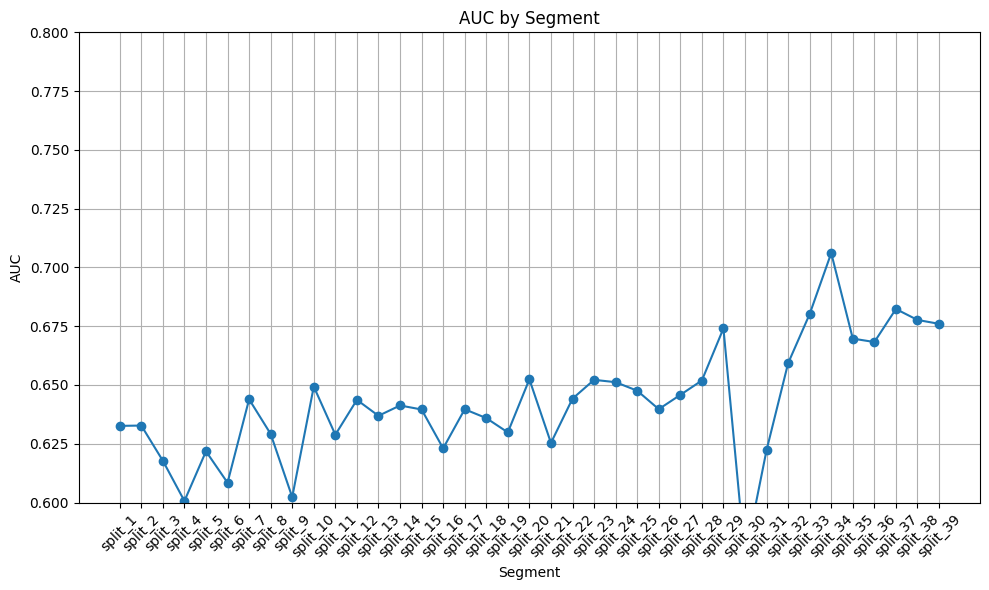

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(oracle_df["segment"], oracle_df["auc"], marker='o')
plt.title("AUC by Segment")
plt.xlabel("Segment")
plt.ylabel("AUC")
plt.ylim(0.6, .8)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Recent split

In [112]:

def utility(tp, tn, fp, fn):
    #return 50*tp - 100*fn - fp * 5
    #return 150*tp + 3*tn - 10*fn - fp * 3
    return 150*tp - 12*fn - fp * 2 + 4*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)
        
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    
    return best_threshold, best_util

def rf(
    final_segments,
    n_previous_splits=1,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize training pool for bandit modes
    first_key = sorted_keys[0]
    first_split = final_segments[first_key]
    last_accepted_data = (first_split[features], first_split['target'])

    for t in range(n_previous_splits, len(sorted_keys)):
        test_key = sorted_keys[t]

        # TRAINING DATA
        if mode == 'oracle':
            train_keys = sorted_keys[t - n_previous_splits:t]
            X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
            y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)
        else:
            X_train, y_train = last_accepted_data

        # TEST DATA
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Safe stratified validation split
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size,
            random_state=random_state, stratify=y_train
        )

        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        model.fit(X_train_fit, y_train_fit)

        # Threshold tuning
        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Decision logic
        if mode == 'oracle':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'bandit':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.ones(len(y_test_proba), dtype=bool)
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # Binary prediction for default (1 = default)
        y_test_pred = (y_test_proba >= best_threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "accuracy": accuracy,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update training pool only for bandit/epsilon
        if mode != 'oracle':
            last_accepted_data = (
                X_test.loc[accept_mask],
                y_test.loc[accept_mask]
            )

    return pd.DataFrame(results)


In [113]:
df_rf_oracle = rf(final_segments, mode='oracle', n_previous_splits=1)
df_rf_bandit = rf(final_segments, mode='bandit', n_previous_splits=1)
df_rf_eps = rf(final_segments, mode='epsilon_greedy', epsilon=0.1)


In [77]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

df_oracle = run_oracle_with_utility_threshold(final_segments, mode='oracle', n_previous_splits=1)
df_oracle

segment  segment_num                 type  threshold  utility  \
0    split_1            1  oracle_util_1splits   0.039744   128898   
1    split_2            2  oracle_util_1splits   0.039744   114846   
2    split_3            3  oracle_util_1splits   0.032308   185198   
3    split_4            4  oracle_util_1splits   0.032308   123130   
4    split_5            5  oracle_util_1splits   0.032308   126464   
5    split_6            6  oracle_util_1splits   0.039744   202904   
6    split_7            7  oracle_util_1splits   0.039744   124024   
7    split_8            8  oracle_util_1splits   0.032308   123944   
8    split_9            9  oracle_util_1splits   0.039744   222044   
9   split_10           10  oracle_util_1splits   0.032308   183336   
10  split_11           11  oracle_util_1splits   0.032308   165752   
11  split_12           12  oracle_util_1splits   0.024872   168582   
12  split_13           13  oracle_util_1splits   0.039744   254088   
13  split_14           14  oracle_util_1splits   0.032308   181958   
14  split_15           15  oracle_util_1splits   0.032308   191856   
15  split_16           16  oracle_util_1splits   0.039744   287650   
16  split_17           17  oracle_util_1splits   0.032308   210738   
17  split_18           18  oracle_util_1splits   0.032308   206900   
18  split_19           19  oracle_util_1splits   0.032308   343404   
19  split_20           20  oracle_util_1splits   0.032308   247516   
20  split_21           21  oracle_util_1splits   0.032308   241262   
21  split_22           22  oracle_util_1splits   0.032308   285622   
22  split_23           23  oracle_util_1splits   0.039744   304258   
23  split_24           24  oracle_util_1splits   0.039744   194042   
24  split_25           25  oracle_util_1splits   0.039744   211218   
25  split_26           26  oracle_util_1splits   0.032308   292046   
26  split_27           27  oracle_util_1splits   0.039744   182018   
27  split_28           28  oracle_util_1splits   0.032308    54326   
28  split_29           29  oracle_util_1splits   0.032308    18420   
29  split_30           30  oracle_util_1splits   0.166154    19910   
30  split_31           31  oracle_util_1splits   0.032308    65686   
31  split_32           32  oracle_util_1splits   0.032308    82466   
32  split_33           33  oracle_util_1splits   0.032308   128096   
33  split_34           34  oracle_util_1splits   0.032308    58126   
34  split_35           35  oracle_util_1splits   0.047179    52218   
35  split_36           36  oracle_util_1splits   0.039744    88728   
36  split_37           37  oracle_util_1splits   0.032308   124518   
37  split_38           38  oracle_util_1splits   0.039744   124772   
38  split_39           39  oracle_util_1splits   0.054615   148822   

    validation_utility       auc    recall  specificity  precision        f1  \
0                26118  0.632609  0.143665     0.939511   0.060333  0.084978   
1                25500  0.632747  0.186190     0.912045   0.056197  0.086335   
2                22696  0.617775  0.388430     0.764680   0.046190  0.082561   
3                36224  0.600655  0.340302     0.803180   0.046530  0.081866   
4                26406  0.621792  0.355792     0.785816   0.041621  0.074523   
5                26000  0.608432  0.267223     0.864035   0.053872  0.089667   
6                40596  0.643912  0.322051     0.842630   0.067037  0.110974   
7                24742  0.629178  0.603793     0.586580   0.047207  0.087568   
8                23820  0.602316  0.253899     0.864820   0.051913  0.086201   
9                45524  0.649323  0.388699     0.791165   0.046017  0.082291   
10               36548  0.628848  0.377586     0.784007   0.048016  0.085197   
11               33862  0.643673  0.667486     0.530688   0.038609  0.072996   
12               36246  0.636893  0.252985     0.870267   0.051600  0.085717   
13               54612  0.641284  0.400332     0.779394   0.047093  0.084273   
14  

In [78]:
# Print as CSV format
print(df_oracle.to_csv(index=False))

segment,segment_num,type,threshold,utility,validation_utility,auc,recall,specificity,precision,f1,actual_default_rate,predicted_default_rate,accept_rate,exploration_rate,tn,fp,fn,tp
split_1,1,oracle_util_1splits,0.03974358974358974,128898,26118,0.6326089708995808,0.1436651583710407,0.9395107033639144,0.06033254156769596,0.08497825359652057,0.026322058122915673,0.022883673102499662,0.9373213434969033,0.0,30722,1978,757,127
split_2,2,oracle_util_1splits,0.03974358974358974,114846,25500,0.6327465151482689,0.18618988902589395,0.9120452259563694,0.056196501674730184,0.08633504859919955,0.02735798137903117,0.025507674113478804,0.9093577115099177,0.0,26297,2536,660,151
split_3,3,oracle_util_1splits,0.03230769230769231,185198,22696,0.6177747638114541,0.3884297520661157,0.7646799506259919,0.046189582774948626,0.08256148195464708,0.028501680978179404,0.03336027261259281,0.7603160667251976,0.0,34692,10676,814,517
split_4,4,oracle_util_1splits,0.03230769230769231,123130,36224,0.6006551733393795,0.

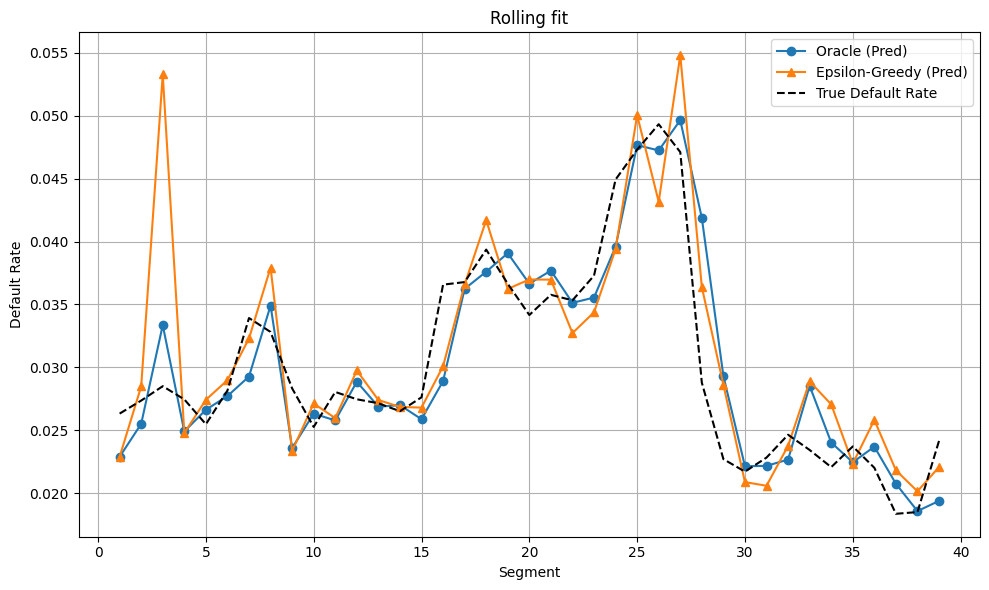

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_rf_oracle['segment_num'], df_rf_oracle['predicted_default_rate'], label='Oracle (Pred)', marker='o')
#plt.plot(df_rf_bandit ['segment_num'], df_rf_bandit ['predicted_default_rate'], label='Bandit (Pred)', marker='x')
plt.plot(df_rf_eps['segment_num'], df_rf_eps['predicted_default_rate'], label='Epsilon-Greedy (Pred)', marker='^')

# All have same true default rate per segment, so just use one:
plt.plot(df_rf_oracle['segment_num'], df_rf_oracle['actual_default_rate'], label='True Default Rate', linestyle='--', color='black')

plt.xlabel('Segment')
plt.ylabel('Default Rate')
plt.title('Rolling fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/Figure3.pdf', format='pdf', bbox_inches='tight')
plt.show()



# Cumulative fit

In [204]:
def utility(tp, tn, fp, fn):
    #return 50*tp - 100*fn - fp * 5
    #return 150*tp + 3*tn - 10*fn - fp * 3
    return 150*tp - 12*fn - fp * 2 + 4*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)
        
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    
    return best_threshold, best_util
def cf(
    final_segments,
    n_previous_splits=1,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize pool with accepted from split_0 (accept all)
    accepted_X = [final_segments['split_0'][features]]
    accepted_y = [final_segments['split_0']['target']]

    for t in range(1, len(sorted_keys)):
        test_key = sorted_keys[t]

        # TRAINING DATA
        if mode == 'oracle':
            train_keys = sorted_keys[:t]
            X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
            y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)
        else:
            X_train = pd.concat(accepted_X, ignore_index=True)
            y_train = pd.concat(accepted_y, ignore_index=True)

        # TEST DATA
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Safe stratified validation split
        stratify = y_train if y_train.nunique() > 1 else None
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size,
            random_state=random_state, stratify=stratify
        )

        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        model.fit(X_train_fit, y_train_fit)

        # Threshold tuning
        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Decision logic
        if mode == 'oracle':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'bandit':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.ones(len(y_test_proba), dtype=bool)
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # Prediction for evaluation
        y_test_pred = (y_test_proba >= best_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "accuracy": accuracy,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update training pool (only for bandit/epsilon)
        if mode != 'oracle':
            accepted_X.append(X_test.loc[accept_mask])
            accepted_y.append(y_test.loc[accept_mask])

    return pd.DataFrame(results)


In [205]:
df_cf_oracle = cf(final_segments, mode='oracle', n_previous_splits=1)
df_cf_bandit = cf(final_segments, mode='bandit', n_previous_splits=1)
df_cf_eps = cf(final_segments, mode='epsilon_greedy', epsilon=0.1)

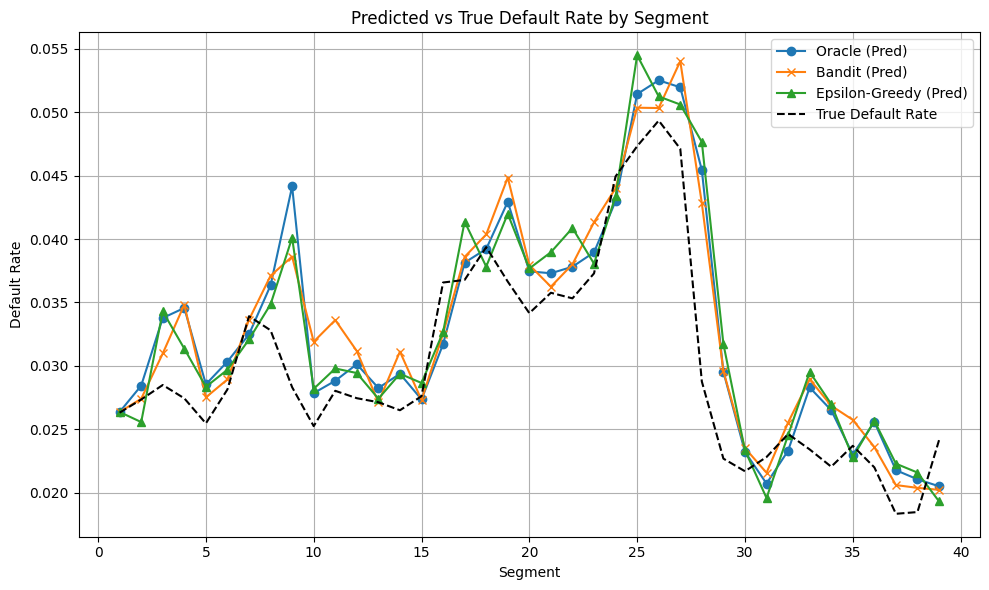

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_oracle['segment_num'], df_oracle['predicted_default_rate'], label='Oracle (Pred)', marker='o')
plt.plot(df_bandit['segment_num'], df_bandit['predicted_default_rate'], label='Bandit (Pred)', marker='x')
plt.plot(df_eps['segment_num'], df_eps['predicted_default_rate'], label='Epsilon-Greedy (Pred)', marker='^')

# All have same true default rate per segment, so just use one:
plt.plot(df_oracle['segment_num'], df_oracle['actual_default_rate'], label='True Default Rate', linestyle='--', color='black')

plt.xlabel('Segment')
plt.ylabel('Default Rate')
plt.title('Predicted vs True Default Rate by Segment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Online gradient descent

In [207]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

def utility(tp, tn, fp, fn):
    return 150*tp - 12*fn - fp * 2 + 4*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = 0.5
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        util = utility(tp, tn, fp, fn)
        if util > best_util:
            best_util = util
            best_threshold = th
    return best_threshold, best_util

def run_ogd_online(
    final_segments,
    epsilon=0.1,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42
):
    from sklearn.linear_model import SGDClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    from sklearn.model_selection import train_test_split

    results = []

    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

    X_train = final_segments['split_0'][features]
    y_train = final_segments['split_0']['target']

    # Define scaler and model
    scaler = StandardScaler()
    clf = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)

    #clf = SGDClassifier(
    #    loss='log_loss',
    #    max_iter=1,
    #   learning_rate='constant',  # constant learning rate strategy
    #    eta0=0.005,                 # initial (and constant) learning rate
    #    tol=None
    #)

    # Initial fit
    X_train_scaled = scaler.fit_transform(X_train)
    clf.partial_fit(X_train_scaled, y_train, classes=[0, 1])

    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(1, len(sorted_keys)):
        split_key = sorted_keys[t]
        test_segment = final_segments[split_key]
        X_test_full = test_segment[features]
        y_test_full = test_segment["target"]

        scaler.partial_fit(X_test_full)
        X_test_scaled = scaler.transform(X_test_full)

        # Split test segment into val/test to tune threshold
        X_val, X_test, y_val, y_test = train_test_split(
            X_test_scaled, y_test_full, test_size=1 - val_size,
            random_state=random_state, stratify=y_test_full if y_test_full.nunique() > 1 else None
        )

        # Tune threshold on validation data
        y_val_proba = clf.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test data
        y_test_proba = clf.predict_proba(X_test)[:, 1]
        policy_accept = y_test_proba < best_threshold

        if mode == 'epsilon_greedy':
            rand = np.random.rand(len(y_test_proba))
            use_policy = rand >= epsilon
            explore_accept = np.ones(len(y_test_proba), dtype=bool)
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (rand < epsilon).mean()
        else:
            accept_mask = policy_accept
            exploration_rate = 0.0

        y_test_pred = (y_test_proba >= best_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        auc = roc_auc_score(y_test, y_test_proba)
        recall = recall_score(y_test, y_test_pred)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        util = utility(tp, tn, fp, fn)

        results.append({
            "segment": split_key,
            "segment_num": int(split_key.split("_")[1]),
            "type": mode,
            "threshold": best_threshold,
            "utility": util,
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "accuracy": accuracy,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "exploration_rate": exploration_rate,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update model
        if mode == 'oracle':
            clf.partial_fit(X_test, y_test, classes=[0, 1])
        else:
            if accept_mask.any():
                clf.partial_fit(X_test[accept_mask], y_test[accept_mask], classes=[0, 1])

    return pd.DataFrame(results)


In [208]:
df_ogd_oracle = run_ogd_online(final_segments, mode='oracle')
df_ogd_bandit = run_ogd_online(final_segments, mode='bandit')
df_ogd_eps = run_ogd_online(final_segments, mode='epsilon_greedy', epsilon=0.1)

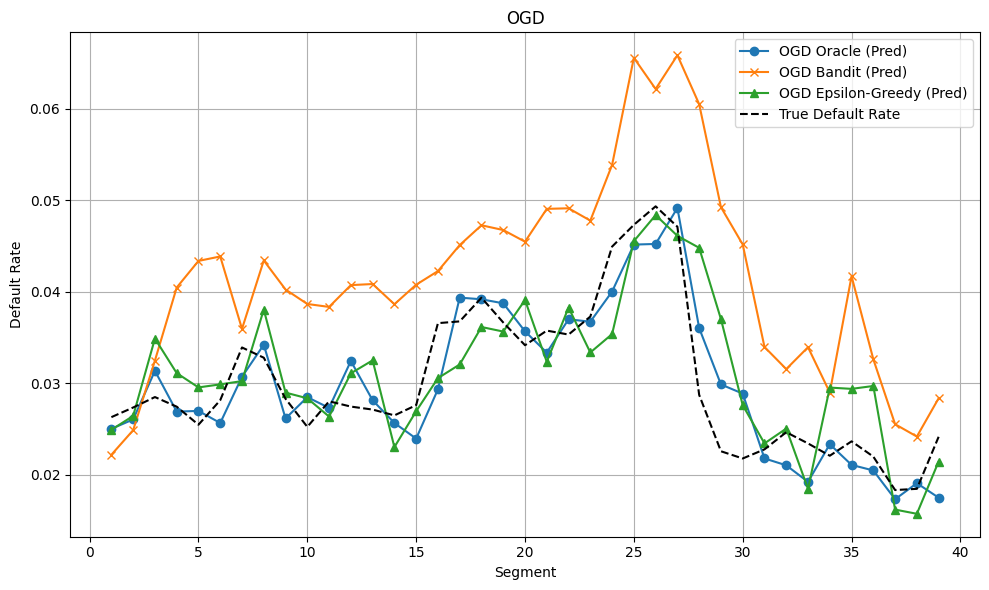

In [201]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_ogd_oracle['segment_num'], df_ogd_oracle['predicted_default_rate'],
         label='OGD Oracle (Pred)', marker='o')
plt.plot(df_ogd_bandit['segment_num'], df_ogd_bandit['predicted_default_rate'],
         label='OGD Bandit (Pred)', marker='x')
plt.plot(df_ogd_eps['segment_num'], df_ogd_eps['predicted_default_rate'],
         label='OGD Epsilon-Greedy (Pred)', marker='^')

# All have the same true default rate per segment, so use one
plt.plot(df_ogd_oracle['segment_num'], df_ogd_oracle['actual_default_rate'],
         label='True Default Rate', linestyle='--', color='black')

plt.xlabel('Segment')
plt.ylabel('Default Rate')
plt.title('OGD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



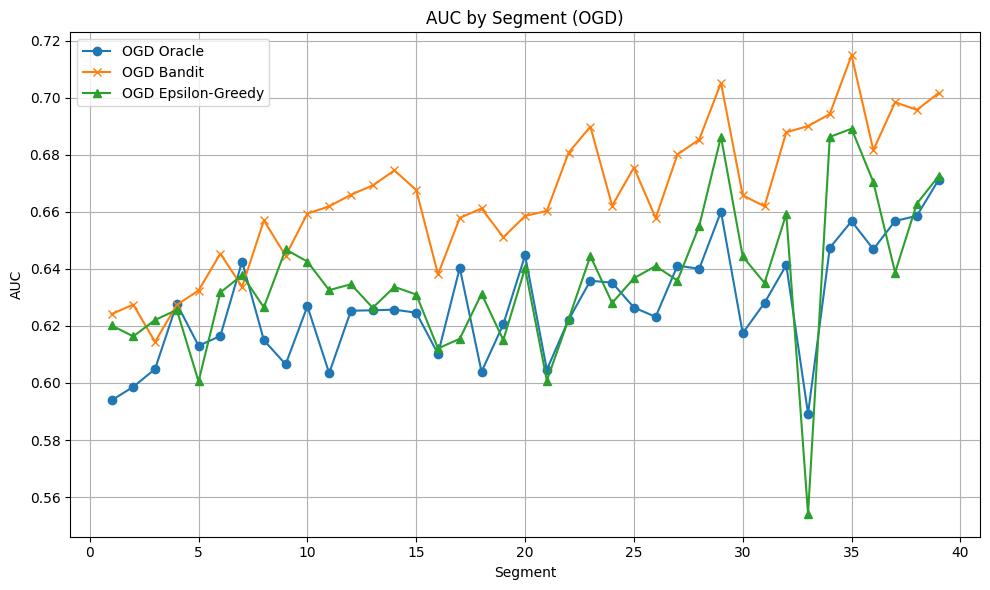

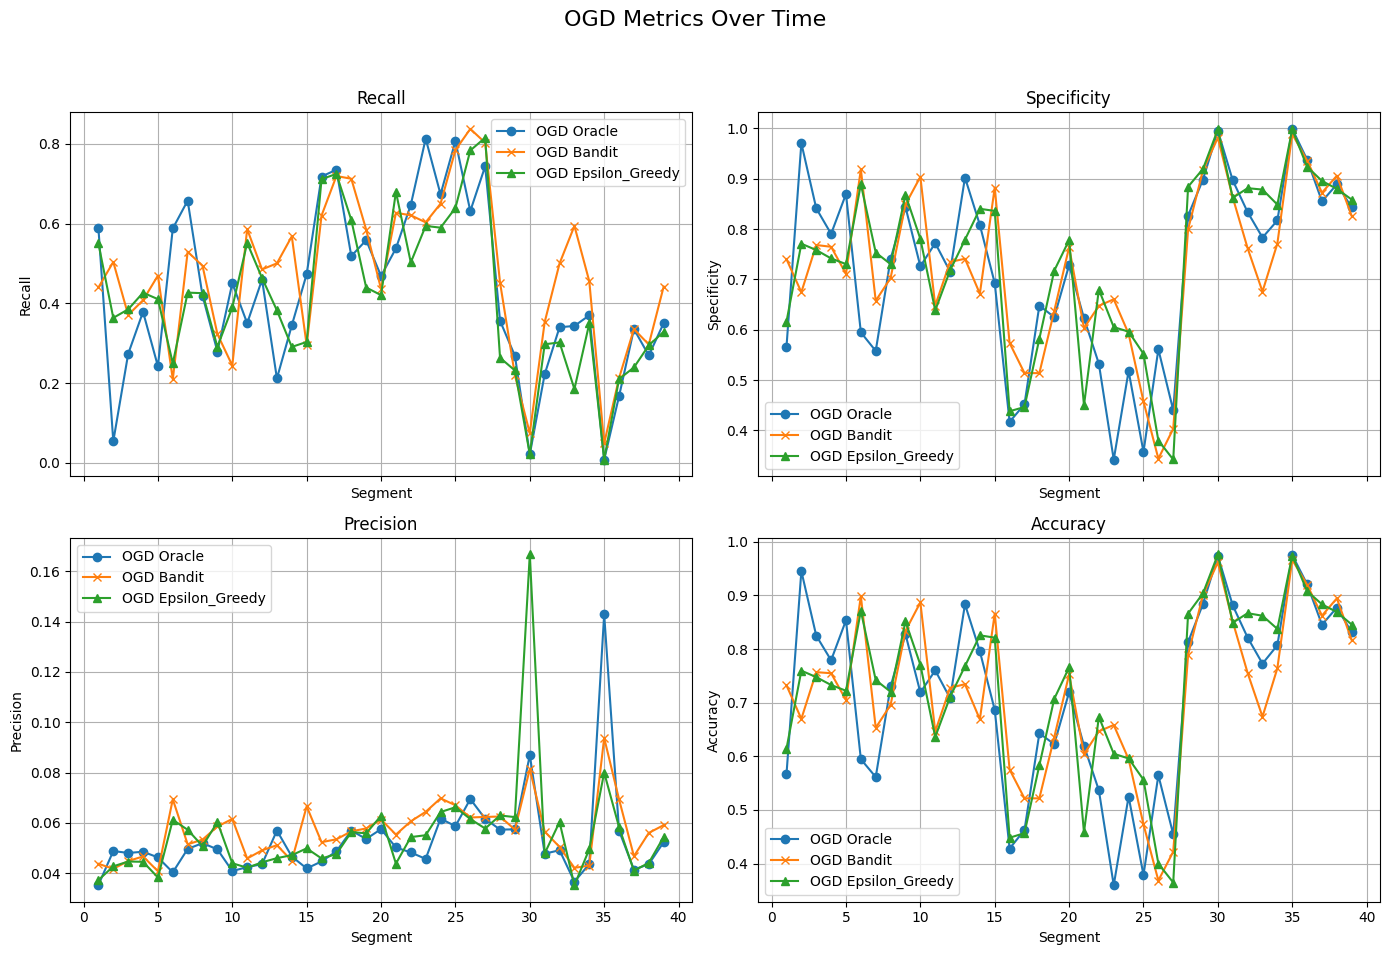

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_ogd_oracle['segment_num'], df_ogd_oracle['auc'], label='OGD Oracle', marker='o')
plt.plot(df_ogd_bandit['segment_num'], df_ogd_bandit['auc'], label='OGD Bandit', marker='x')
plt.plot(df_ogd_eps['segment_num'], df_ogd_eps['auc'], label='OGD Epsilon-Greedy', marker='^')

plt.xlabel('Segment')
plt.ylabel('AUC')
plt.title('AUC by Segment (OGD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Grid of 4 metrics: recall, specificity, precision, f1
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

metrics = ['recall', 'specificity', 'precision', 'accuracy']
titles = ['Recall', 'Specificity', 'Precision', 'Accuracy']
markers = {'oracle': 'o', 'bandit': 'x', 'epsilon_greedy': '^'}

dfs = {
    'oracle': df_ogd_oracle,
    'bandit': df_ogd_bandit,
    'epsilon_greedy': df_ogd_eps
}

for ax, metric, title in zip(axs.flat, metrics, titles):
    for label, df in dfs.items():
        ax.plot(df['segment_num'], df[metric], label=f'OGD {label.title()}', marker=markers[label])
    ax.set_title(title)
    ax.set_xlabel('Segment')
    ax.set_ylabel(title)
    ax.grid(True)
    ax.legend()

plt.suptitle('OGD Metrics Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Random Forest

In [171]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

def utility(tp, tn, fp, fn):
    return 50 * tp - 100 * fn - fp * 5

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None

    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)

        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th

    return best_threshold, best_util

def run_oracle_with_utility_threshold(
    final_segments,
    n_previous_splits=1,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize training pool for bandit modes
    first_key = sorted_keys[0]
    first_split = final_segments[first_key]
    last_accepted_data = (first_split[features], first_split['target'])

    for t in range(n_previous_splits, len(sorted_keys)):
        test_key = sorted_keys[t]

        # TRAINING DATA
        if mode == 'oracle':
            train_keys = sorted_keys[t - n_previous_splits:t]
            X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
            y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)
        else:
            X_train, y_train = last_accepted_data

        # TEST DATA
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Safe stratified validation split
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size,
            random_state=random_state, stratify=y_train
        )

        # === Random Forest model with default parameters ===
        model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=random_state))
        model.fit(X_train_fit, y_train_fit)

        # Threshold tuning
        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Decision logic
        if mode == 'oracle':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'bandit':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.ones(len(y_test_proba), dtype=bool)
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # Binary prediction for default (1 = default)
        y_test_pred = (y_test_proba >= best_threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "f1": f1,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update training pool only for bandit/epsilon
        if mode != 'oracle':
            last_accepted_data = (
                X_test.loc[accept_mask],
                y_test.loc[accept_mask]
            )

    return pd.DataFrame(results)


In [172]:
df_oracle = run_oracle_with_utility_threshold(final_segments, mode='oracle', n_previous_splits=1)
df_bandit = run_oracle_with_utility_threshold(final_segments, mode='bandit', n_previous_splits=1)
df_eps = run_oracle_with_utility_threshold(final_segments, mode='epsilon_greedy', epsilon=0.1)

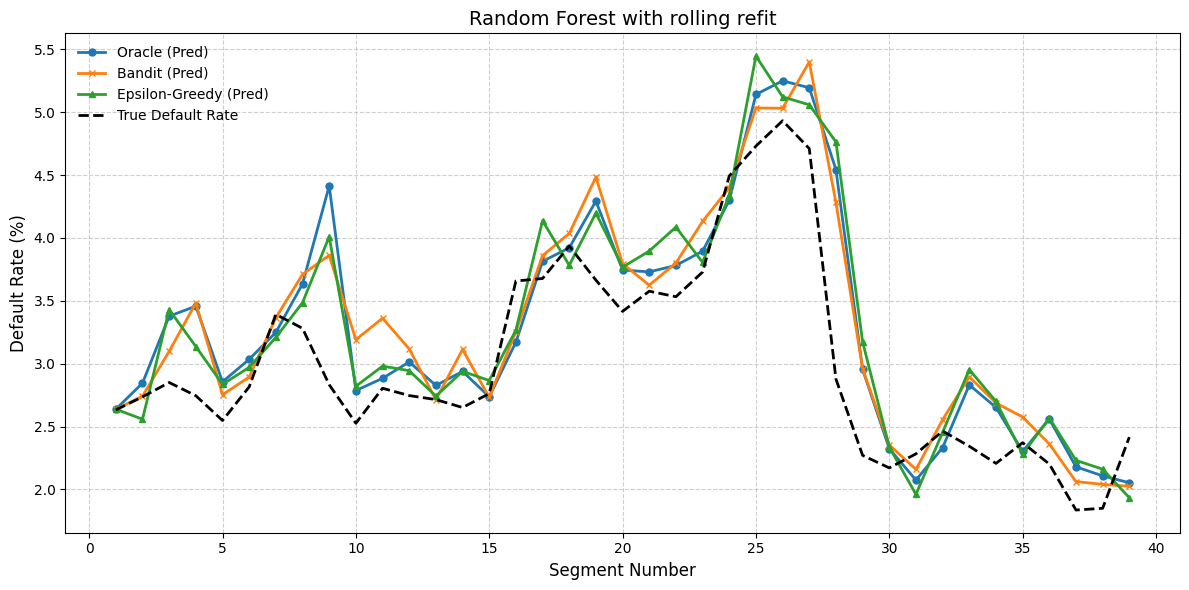

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot predicted default rates
plt.plot(df_oracle['segment_num'], df_oracle['predicted_default_rate'] * 100,
         label='Oracle (Pred)', marker='o', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['predicted_default_rate'] * 100,
         label='Bandit (Pred)', marker='x', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['predicted_default_rate'] * 100,
         label='Epsilon-Greedy (Pred)', marker='^', linestyle='-', linewidth=2, markersize=5)

# True default rate (same across all)
plt.plot(df_oracle['segment_num'], df_oracle['actual_default_rate'] * 100,
         label='True Default Rate', linestyle='--', color='black', linewidth=2)

# Axis labels and title
plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.title('Random Forest with rolling refit', fontsize=14)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=10, frameon=False)

# Improve spacing
plt.tight_layout()
plt.savefig('../Figures/Figure4.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


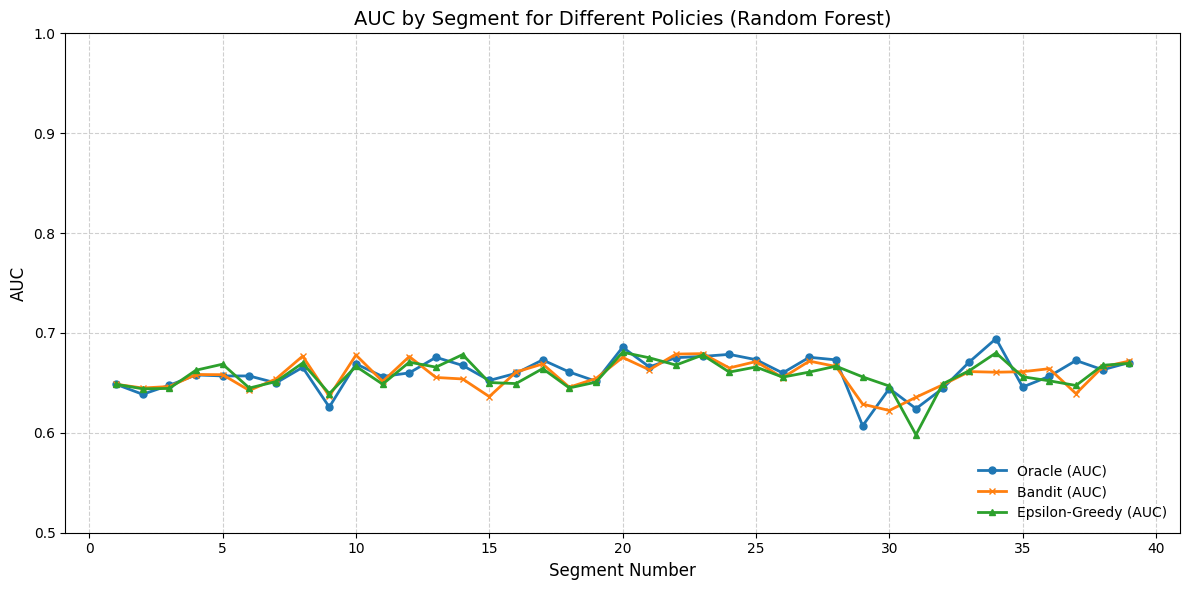

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot AUCs
plt.plot(df_oracle['segment_num'], df_oracle['auc'],
         label='Oracle (AUC)', marker='o', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['auc'],
         label='Bandit (AUC)', marker='x', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['auc'],
         label='Epsilon-Greedy (AUC)', marker='^', linestyle='-', linewidth=2, markersize=5)

# Axis labels and title
plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC by Segment for Different Policies (Random Forest)', fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=10, frameon=False)

plt.ylim(0.5, 1.0)  # optional: to keep y-axis focused on meaningful AUC range
plt.tight_layout()
plt.show()


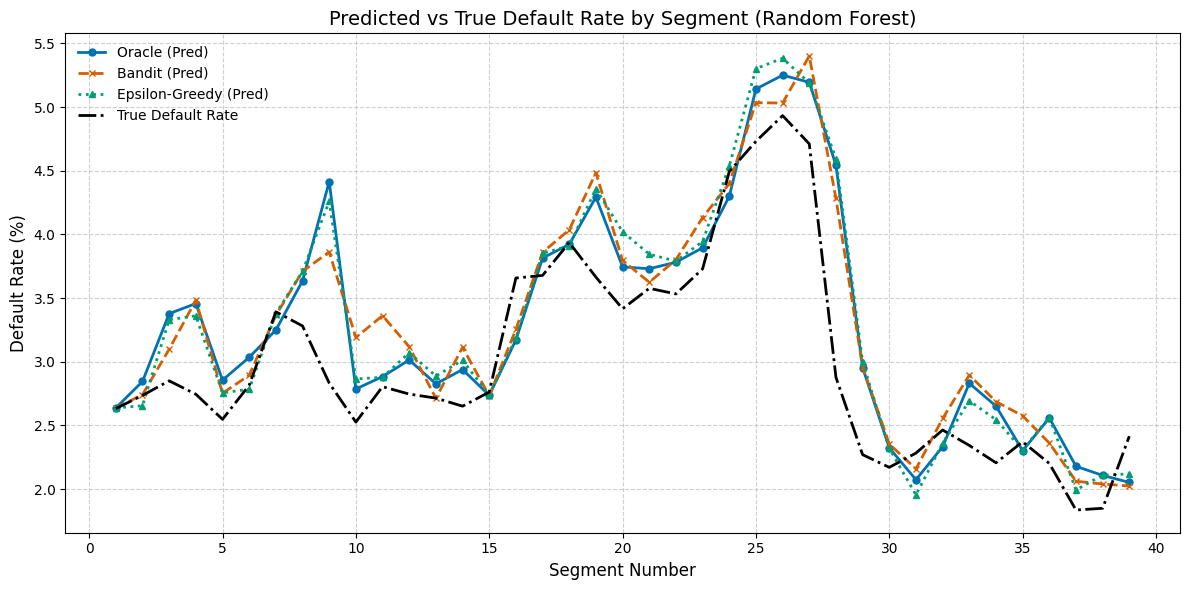

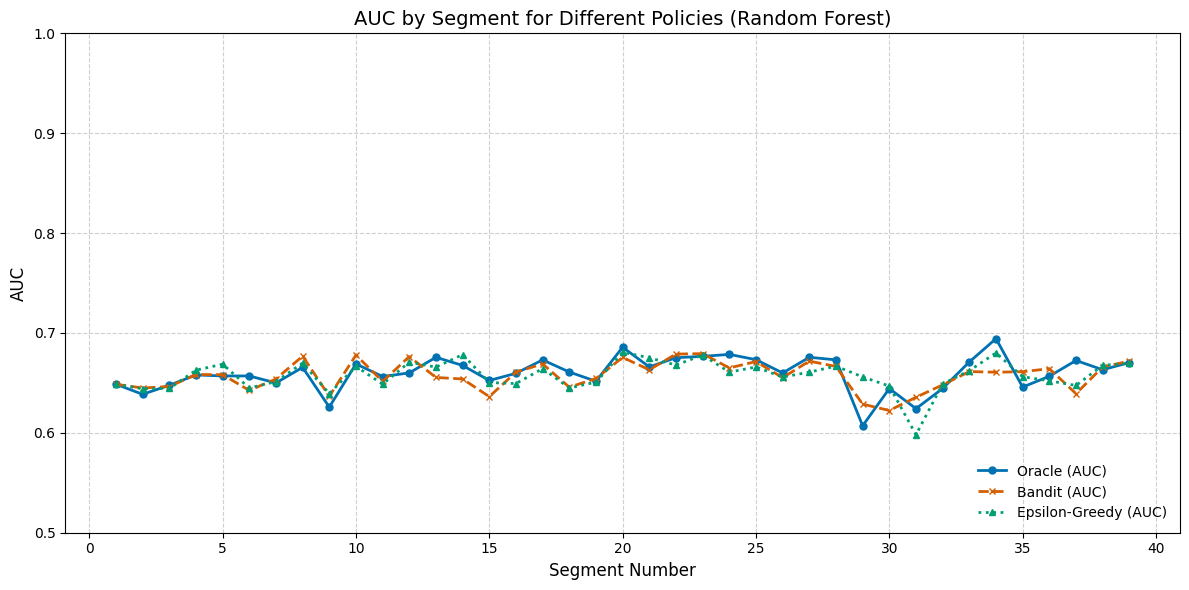

In [21]:
import matplotlib.pyplot as plt
from cycler import cycler

# Use a colorblind-friendly color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=['#0072B2', '#D55E00', '#009E73'])
plt.figure(figsize=(12, 6))

plt.plot(df_oracle['segment_num'], df_oracle['predicted_default_rate'] * 100,
         label='Oracle (Pred)', linestyle='-', marker='o', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['predicted_default_rate'] * 100,
         label='Bandit (Pred)', linestyle='--', marker='x', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['predicted_default_rate'] * 100,
         label='Epsilon-Greedy (Pred)', linestyle=':', marker='^', linewidth=2, markersize=5)

# True values
plt.plot(df_oracle['segment_num'], df_oracle['actual_default_rate'] * 100,
         label='True Default Rate', linestyle='-.', color='black', linewidth=2)

plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.title('Predicted vs True Default Rate by Segment (Random Forest)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=10, frameon=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(df_oracle['segment_num'], df_oracle['auc'],
         label='Oracle (AUC)', linestyle='-', marker='o', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['auc'],
         label='Bandit (AUC)', linestyle='--', marker='x', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['auc'],
         label='Epsilon-Greedy (AUC)', linestyle=':', marker='^', linewidth=2, markersize=5)

plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC by Segment for Different Policies (Random Forest)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=10, frameon=False)
plt.ylim(0.5, 1.0)  # Focus on meaningful AUC range
plt.tight_layout()
plt.show()


# Plots

In [153]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set clean style with white background
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

def create_algorithm_plots(results_df, figsize=(18, 12)):
    algorithms = ['rolling_refit', 'cumulative_refit', 'ogd']
    feedback_systems = ['bandit', 'epsilon_greedy', 'oracle']
    
    # Define better colors for each feedback system - more distinct and colorblind friendly
    colors = {
        'bandit': '#E74C3C',        # Red
        'epsilon_greedy': '#3498DB', # Blue  
        'oracle': '#2ECC71'         # Green
    }
    
    # Create figure with subplots - 2 rows, 3 columns
    fig = plt.figure(figsize=figsize)
    
    # Plot 1-3: Default Rates for each algorithm (actual + predicted)
    for i, algorithm in enumerate(algorithms):
        ax = plt.subplot(2, 3, i + 1)
        
        # Plot actual default rate only once (it's the same for all feedback systems)
        first_feedback = feedback_systems[0]
        data_actual = results_df[(results_df['algorithm'] == algorithm) & 
                               (results_df['feedback'] == first_feedback)]
        
        if not data_actual.empty:
            ax.plot(data_actual['segment_num'], data_actual['actual_default_rate'], 
                   color='#2C3E50', linestyle='-', linewidth=3, 
                   label='actual', marker='o', markersize=5, alpha=0.9)
        
        # Plot predicted default rates for each feedback system
        for feedback in feedback_systems:
            data = results_df[(results_df['algorithm'] == algorithm) & 
                            (results_df['feedback'] == feedback)]
            
            if not data.empty:
                ax.plot(data['segment_num'], data['predicted_default_rate'], 
                       color=colors[feedback], linestyle='--', linewidth=3, 
                       label=f'{feedback} (predicted)', marker='s', markersize=4, alpha=0.8)
        
        ax.set_title(f'{algorithm.replace("_", " ").title()}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Segment Number', fontsize=12)
        ax.set_ylabel('Default Rate', fontsize=12)
        ax.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
    
    # Plot 4-6: AUC for each algorithm
    for i, algorithm in enumerate(algorithms):
        ax = plt.subplot(2, 3, i + 4)
        
        for feedback in feedback_systems:
            data = results_df[(results_df['algorithm'] == algorithm) & 
                            (results_df['feedback'] == feedback)]
            
            if not data.empty:
                ax.plot(data['segment_num'], data['auc'], 
                       color=colors[feedback], linestyle='-', linewidth=3, 
                       label=feedback, marker='^', markersize=5)
        

        ax.set_xlabel('Segment Number', fontsize=12)
        ax.set_ylabel('AUC', fontsize=12)
        ax.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
        ax.set_ylim(0.4, 0.75)
    
    # Add single legend at the bottom of the figure
    handles = []
    labels = []
    
    # Add actual line
    line_actual = plt.Line2D([0], [0], color='#2C3E50', linewidth=3, linestyle='-', marker='o', markersize=5)
    handles.append(line_actual)
    labels.append('actual')
    
    # Add one entry for each feedback system (covers both predicted and AUC)
    for feedback in feedback_systems:
        line_feedback = plt.Line2D([0], [0], color=colors[feedback], linewidth=3, linestyle='-', markersize=4)
        handles.append(line_feedback)
        labels.append(feedback)
    
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig

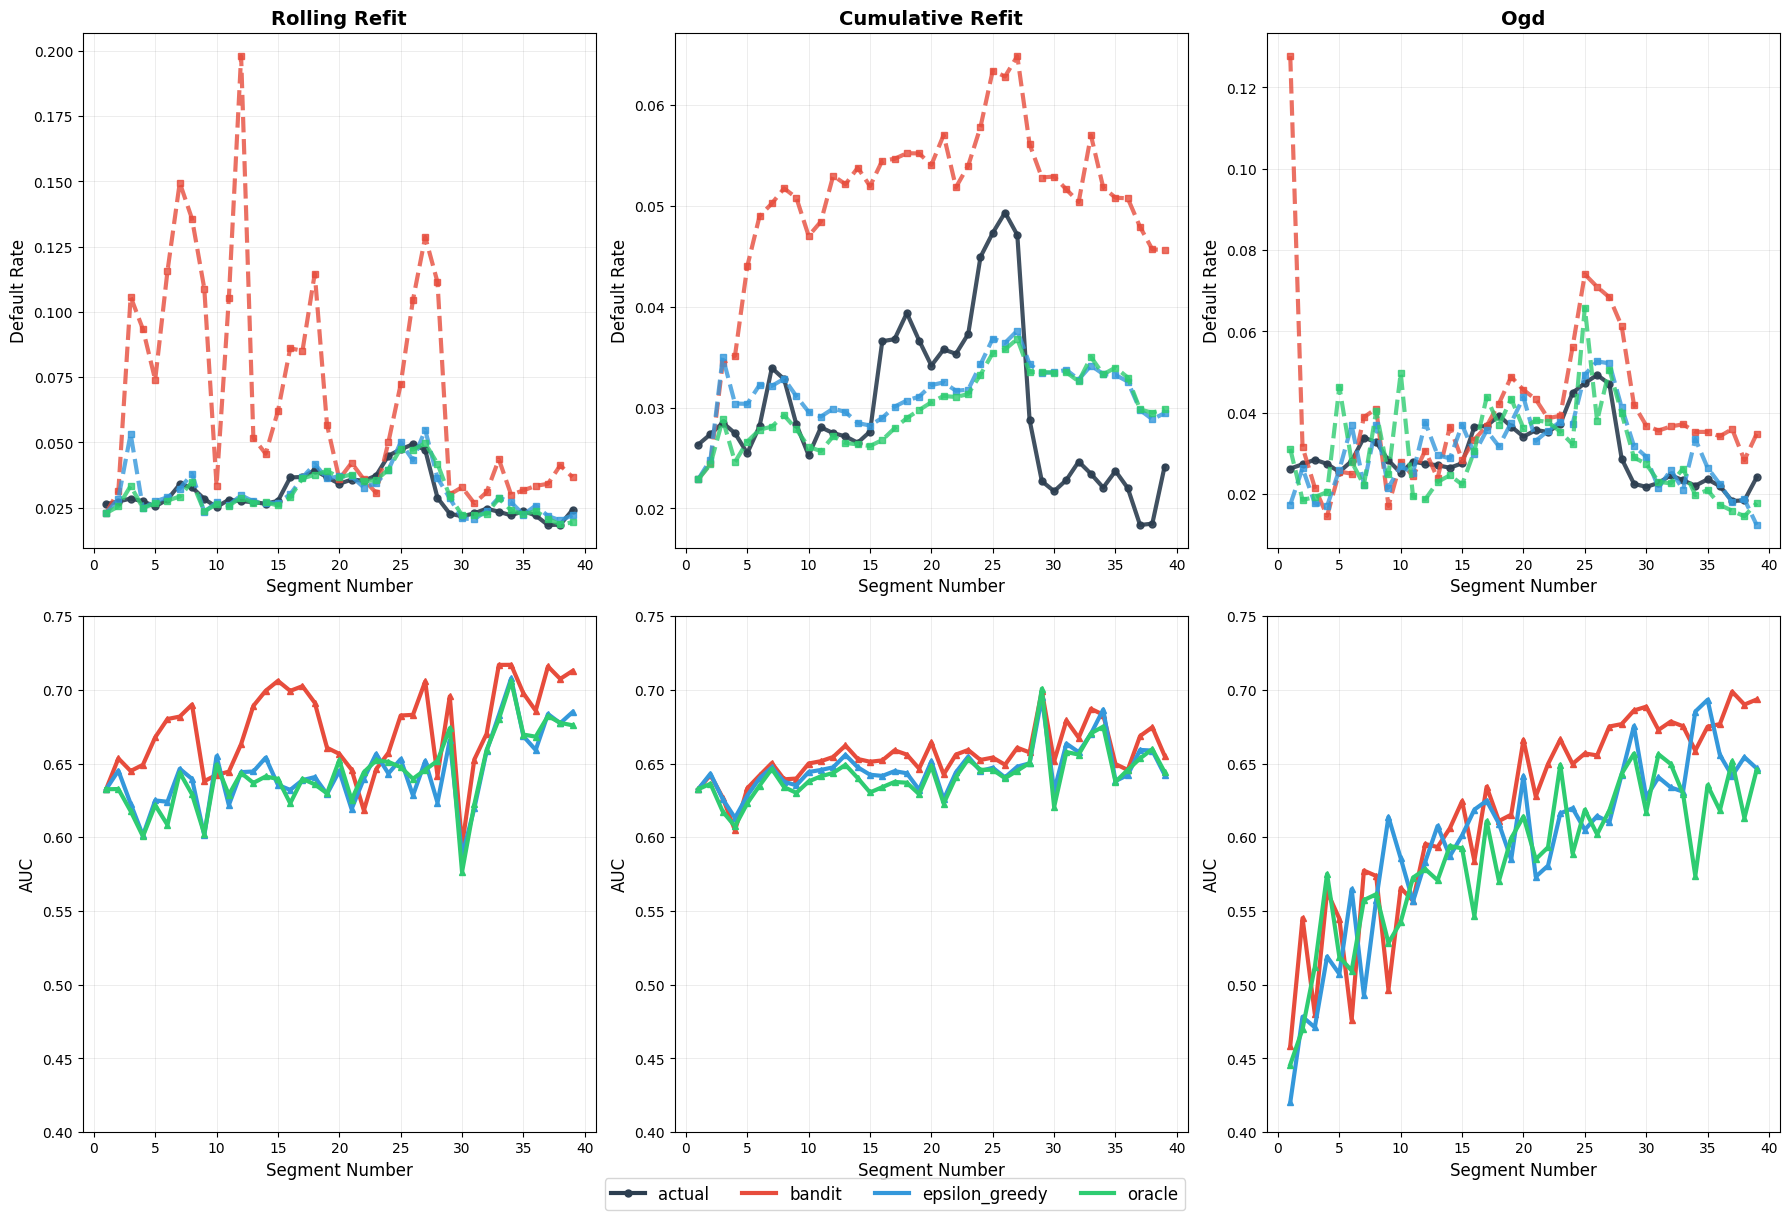

In [209]:
# First, combine all your DataFrames
df_cf_oracle['algorithm'] = 'cumulative_refit'
df_cf_oracle['feedback'] = 'oracle'

df_cf_bandit['algorithm'] = 'cumulative_refit'
df_cf_bandit['feedback'] = 'bandit'

df_cf_eps['algorithm'] = 'cumulative_refit'
df_cf_eps['feedback'] = 'epsilon_greedy'

df_rf_oracle['algorithm'] = 'rolling_refit'
df_rf_oracle['feedback'] = 'oracle'

df_rf_bandit['algorithm'] = 'rolling_refit'
df_rf_bandit['feedback'] = 'bandit'

df_rf_eps['algorithm'] = 'rolling_refit'
df_rf_eps['feedback'] = 'epsilon_greedy'

df_ogd_oracle['algorithm'] = 'ogd'
df_ogd_oracle['feedback'] = 'oracle'

df_ogd_bandit['algorithm'] = 'ogd'
df_ogd_bandit['feedback'] = 'bandit'

df_ogd_eps['algorithm'] = 'ogd'
df_ogd_eps['feedback'] = 'epsilon_greedy'

# Combine all DataFrames
results_df = pd.concat([
    df_cf_oracle, df_cf_bandit, df_cf_eps,
    df_rf_oracle, df_rf_bandit, df_rf_eps,
    df_ogd_oracle, df_ogd_bandit, df_ogd_eps
], ignore_index=True)

# Run the plotting function
fig1 = create_algorithm_plots(results_df)
fig1.savefig('../Figures/Figure1.pdf', format='pdf', bbox_inches='tight', dpi=300)

In [210]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set clean style with white background
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

def create_metrics_plots(results_df, figsize=(18, 16)):
    algorithms = ['rolling_refit', 'cumulative_refit', 'ogd']
    feedback_systems = ['bandit', 'epsilon_greedy', 'oracle']
    metrics = ['accuracy', 'precision', 'recall', 'specificity']
    
    # Define better colors for each feedback system - more distinct and colorblind friendly
    colors = {
        'bandit': '#E74C3C',        # Red
        'epsilon_greedy': '#3498DB', # Blue  
        'oracle': '#2ECC71'         # Green
    }
    
    # Create figure with 4x3 subplots (4 metrics x 3 algorithms)
    fig, axes = plt.subplots(4, 3, figsize=figsize)
    fig.suptitle('Performance Metrics Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    for i, metric in enumerate(metrics):
        for j, algorithm in enumerate(algorithms):
            ax = axes[i, j]
            
            # Plot each feedback system for this algorithm and metric
            for feedback in feedback_systems:
                data = results_df[(results_df['algorithm'] == algorithm) & 
                                (results_df['feedback'] == feedback)]
                
                if not data.empty:
                    ax.plot(data['segment_num'], data[metric], 
                           color=colors[feedback], 
                           linestyle='-', 
                           linewidth=3, 
                           label=feedback, 
                           marker='o', 
                           markersize=4, 
                           alpha=0.8)
            
            # Formatting
            if i==0:
                title = f'{algorithm.replace("_", " ").title()}'
                ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Segment Number', fontsize=10)
            ax.set_ylabel(metric.title(), fontsize=10)
            ax.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
            
            # Set y-limits based on metric
            if metric == 'precision':
                ax.set_ylim(0, 0.2)
            else:
                ax.set_ylim(0, 1)
    
    # Create single legend for all plots
    handles = []
    labels = []
    
    # Add one entry for each feedback system
    for feedback in feedback_systems:
        line = plt.Line2D([0], [0], 
                        color=colors[feedback], 
                        linestyle='-', 
                        linewidth=3, 
                        marker='o', 
                        markersize=4)
        handles.append(line)
        labels.append(feedback)
    
    # Add legend at the bottom
    fig.legend(handles, labels, 
              loc='lower center', 
              bbox_to_anchor=(0.5, -0.02), 
              ncol=3, 
              fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, bottom=0.08)  # Make room for title and legend
    plt.show()
    
    return fig

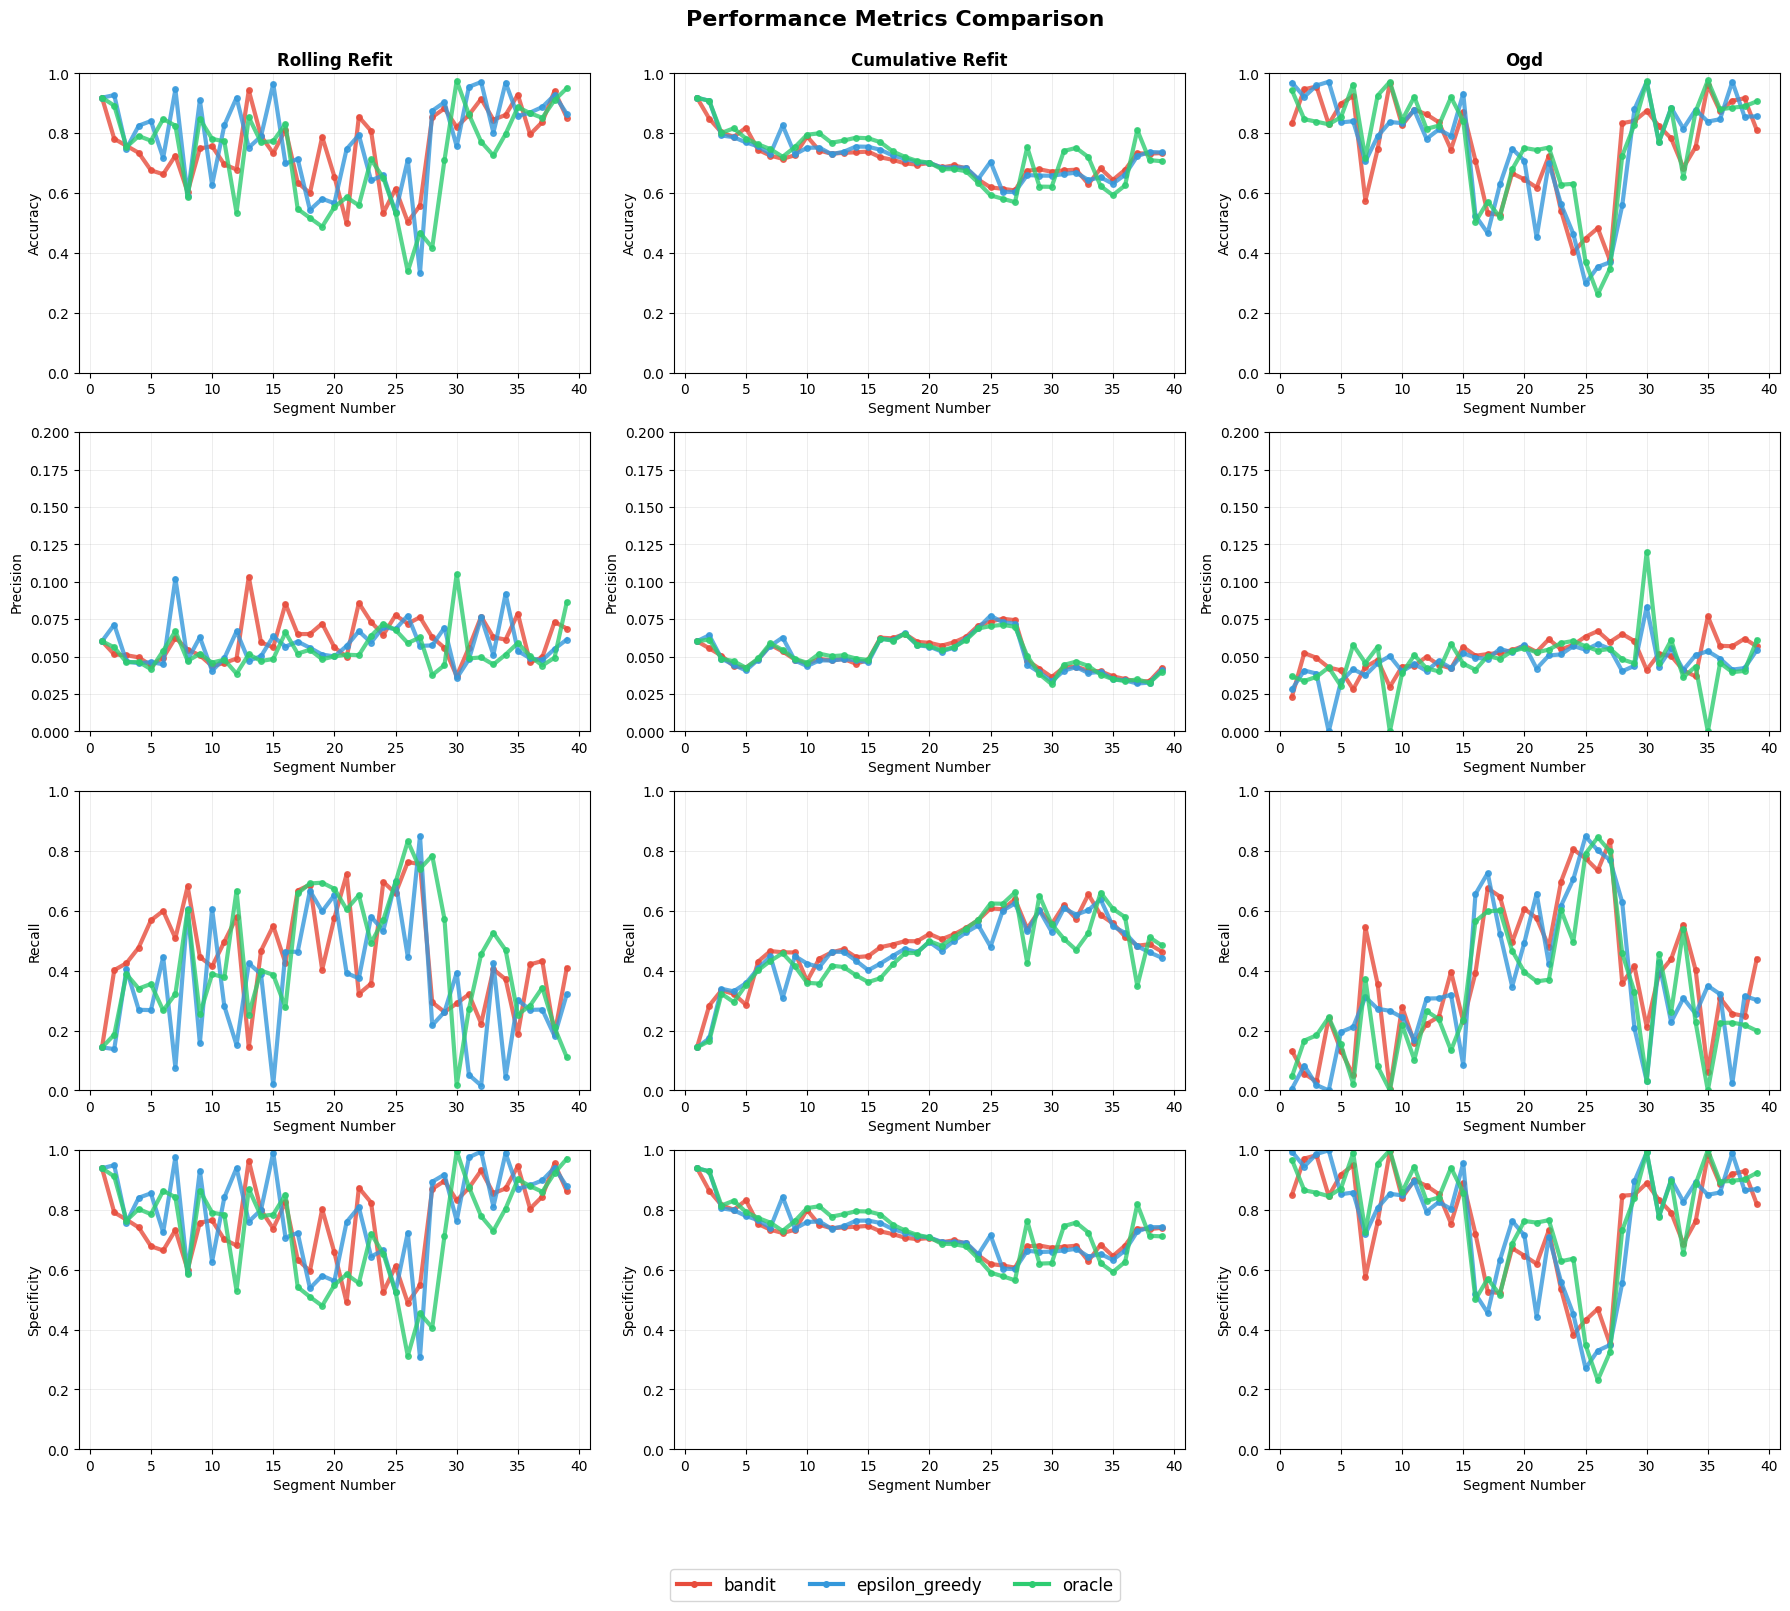

In [211]:
fig2 = create_metrics_plots(results_df)
fig2.savefig('../Figures/Figure2.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Utility optimisation 

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Utility factory
def make_utility(tp_weight, tn_weight):
    def utility(tp, tn, fp, fn):
        return tp_weight * tp + tn_weight * tn
    return utility

# 2. Oracle threshold tuner (cheating on test set)
def find_best_threshold_oracle(y_true, y_proba, thresholds, utility):
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)
        
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    
    return best_threshold, best_util

# 3. Main evaluation loop for oracle and fool
def evaluate_x_values(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.3, 40),
    random_state=42
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for x in x_values:
        utility_fn = make_utility(tp_weight=x, tn_weight=1)  

        for t in range(0, len(sorted_keys)):
            test_key = sorted_keys[t]

            X_test = final_segments[test_key][features]
            y_test = final_segments[test_key]['target']

            # === ORACLE === #
            # Train and test on the same split
            model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
            model_oracle.fit(X_test, y_test)  # train on same set as predict
            y_test_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]

            best_threshold, best_util = find_best_threshold_oracle(y_test, y_test_proba_oracle, thresholds, utility_fn)
            y_pred_oracle = (y_test_proba_oracle >= best_threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()

            results.append({
                "x": x,
                "segment": test_key,
                "mode": "oracle",
                "threshold": best_threshold,
                "utility": utility_fn(tp, tn, fp, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": (y_pred_oracle == 0).mean()
            })

            # === FOOL === #
            y_pred_fool = np.zeros_like(y_test)  # accepts everyone
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fool).ravel()

            results.append({
                "x": x,
                "segment": test_key,
                "mode": "fool",
                "threshold": None,
                "utility": utility_fn(tp, tn, fp, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": 1.0
            })

    return pd.DataFrame(results)


In [15]:
x_values = np.append(1, np.arange(10, 151, 10))
  # From 0.1 to 10 (log scale)
results_df = evaluate_x_values(
    final_segments=final_segments,
    x_values=x_values,
    thresholds=np.linspace(0.01, 0.2, 40), 
    random_state=42
)


In [17]:
results_df

x   segment    mode  threshold  utility   tp     tn     fp   fn  \
0       1   split_0  oracle   0.300000    34701    1  34700      4  871   
1       1   split_0    fool        NaN    34704    0  34704      0  872   
2       1   split_1  oracle   0.292564    32692    0  32692      8  884   
3       1   split_1    fool        NaN    32700    0  32700      0  884   
4       1   split_2  oracle   0.300000    28812    2  28810     23  809   
...   ...       ...     ...        ...      ...  ...    ...    ...  ...   
1275  150  split_37    fool        NaN    31284    0  31284      0  585   
1276  150  split_38  oracle   0.010000    88813  527   9763  21763   67   
1277  150  split_38    fool        NaN    31526    0  31526      0  594   
1278  150  split_39  oracle   0.010000   139182  912   2382  35068   15   
1279  150  split_39    fool        NaN    37450    0  37450      0  927   

      accept_rate  segment_num  
0        0.999859            0  
1        1.000000            0  
2        0.999762            1  
3        1.000000            1  
4        0.999157            2  
...           ...          ...  
1275     1.000000           37  
1276     0.306040           38  
1277     1.000000           38  
1278     0.062459           39  
1279     1.000000           39  

[1280 rows x 11 columns]

In [20]:
pivot

mode    x   segment     fool    oracle  reward_gap
0       1   split_0  34704.0   34701.0        -3.0
1       1   split_1  32700.0   32692.0        -8.0
2       1  split_10  45069.0   45066.0        -3.0
3       1  split_11  40205.0   40202.0        -3.0
4       1  split_12  43242.0   43233.0        -9.0
..    ...       ...      ...       ...         ...
635   150   split_5  32360.0  126533.0     94173.0
636   150   split_6  49601.0  215732.0    166131.0
637   150   split_7  27769.0  146291.0    118522.0
638   150   split_8  27974.0  142381.0    114407.0
639   150   split_9  54986.0  240805.0    185819.0

[640 rows x 5 columns]

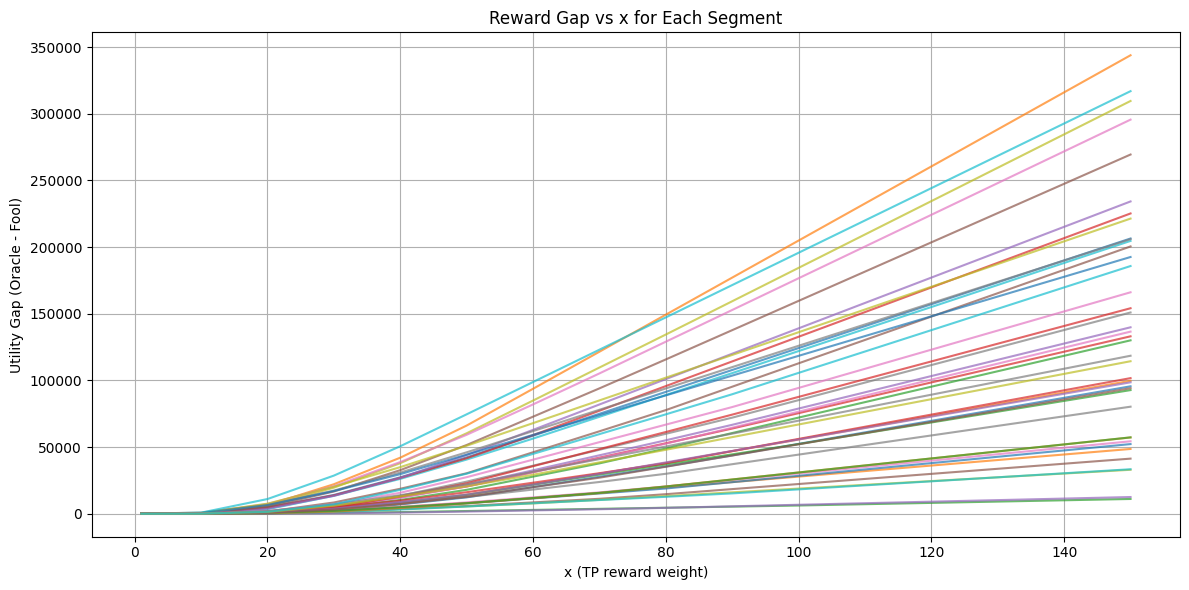

In [19]:
# Pivot to get both utilities in the same row
pivot = results_df.pivot_table(index=['x', 'segment'], columns='mode', values='utility').reset_index()
pivot['reward_gap'] = pivot['oracle'] - pivot['fool']

# Plot reward gap
plt.figure(figsize=(12, 6))
for segment in sorted(pivot['segment'].unique()):
    subset = pivot[pivot['segment'] == segment]
    plt.plot(subset['x'], subset['reward_gap'], label=segment, alpha=0.7)

plt.xlabel('x (TP reward weight)')
plt.ylabel('Utility Gap (Oracle - Fool)')
plt.title('Reward Gap vs x for Each Segment')
plt.grid(True)
plt.tight_layout()
plt.show()
